In [1]:
import eccodes as ec
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import testbedutils as tu
from global_land_mask import globe
from scipy.interpolate import RegularGridInterpolator as RGI
from sklearn.metrics import roc_auc_score, roc_curve, auc, brier_score_loss
from sklearn.calibration import calibration_curve
from cycler import cycler
import concurrent.futures
import os

# Read in C-LAEF        (the hres model)
# Read in AR-CHaMo      (the lres model)
# Read in observations  
# Interpolate AR-CHaMo to C-LAEF grid
# Find best mix

eswdbasedir     = '/home/testbed/wx/obs/eswd'
verif_path_hres = '/home/testbed/data/models/archamo-eps/verif_hres'
domain          = 'CEU'
hazardtype      = 'HAIL'
ni, nj          = 1800, 901
nm = 51 # Number of members

hazardtype_long = {'LIGHTNING': 'prob_lightning',\
                   'HAIL'     : 'prob_hail_ge2cm',\
                   'SIGHAIL'  : 'prob_hail_ge5cm', } 

forecastbasedir = '/home/testbed/data/models/archamo-eps' 
c_laef_path     = '/mnt/essl_nas05/work/pieterg/PreCAST/c-laef' #'/mnt/essl_nas05/work/pieterg/PreCAST/upscaled'


No tempdir indicated, assuming /tmp should be used.


In [2]:
# Code to Preprocess ESWD observations

In [20]:
def ReadHRESForecast(init_dtg):

    gribfile = c_laef_path + '/' + str(init_dtg) + '/hail_prob_23_' + str(init_dtg) + '_upsc10.grb'
    grib_filehandle = open(gribfile, 'rb')
    
    print(gribfile)

    index_keys = ["endStep", "Ni", "Nj", "iDirectionIncrementInDegrees", "jDirectionIncrementInDegrees", \
                  "latitudeOfFirstGridPointInDegrees", "longitudeOfFirstGridPointInDegrees", \
                  "latitudeOfLastGridPointInDegrees", "longitudeOfLastGridPointInDegrees"]

    messages = []

    i = 0
    while 1:

        my_message = {}

        tries = 0
        grib_message_id = ec.codes_grib_new_from_file(grib_filehandle)

        if grib_message_id == None: # last message in grib file
            break

        for key in index_keys:
            try:
                my_message[key] = ec.codes_get(grib_message_id, key)
                my_message['values'] = ec.codes_get_values(grib_message_id)
    #            ec.codes_release(grib_message_id)
            except:
                my_message[key] = None

        messages.append(my_message)

    # Put forecasts in numpy array. 

    hres_fcst = np.empty((len(messages), messages[0]['Ni'] * messages[0]['Nj']), dtype=np.float32)
    hres_fcst_steps = []
    
    for my_message in messages:

        fh = my_message['endStep']
        hres_fcst[fh, :] = my_message['values']
        hres_fcst_steps.append(fh)

    hres_ni  = messages[0]['Ni']
    hres_nj  = messages[0]['Nj']
    lat_min  = messages[0]['latitudeOfFirstGridPointInDegrees']
    lat_max  = messages[0]['latitudeOfLastGridPointInDegrees']
    lon_min  = messages[0]['longitudeOfFirstGridPointInDegrees']
    lon_max  = messages[0]['longitudeOfLastGridPointInDegrees']

    hres_lats            = np.linspace(lat_min, lat_max, num=hres_nj)
    hres_lons            = np.linspace(lon_min, lon_max, num=hres_ni)
    hres_lons, hres_lats = np.meshgrid(hres_lons, hres_lats)
    hres_nsteps          = len(hres_fcst_steps)

    return hres_lats, hres_lons, hres_fcst, hres_ni, hres_nj, hres_nsteps


def ReadAndWriteObservations(hazardtype, dtg, lats, lons, domain, period_in_hours, max_dist):

    # This function calls both the read and the write function for the observations.
    # It is defined separately, so both reading and writing can easily be called 
    # as a single job in a thread pool
    
    observations = ReadObservations(hazardtype, dtg, lats, lons, period_in_hours, max_dist, filter_land=True)
    WriteObservations(observations, dtg, domain, period_in_hours, hazardtype)

    return 


def WriteObservations(observations, dtg, domain, period_in_hours, hazard):

    # This function writes gridded observations to disk
    
    directory = verif_path_hres + '/' + domain + '/' + hazard
    filename = directory + '/' + str(dtg) + '_' + str(period_in_hours) + '_obs.npy'
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    np.save(filename, observations)
    tu.Timestamp('Saved obs to: ' + filename)
    
    
def ReadObservations(hazardtype, dtg, lats, lons, period_in_hours, max_dist, filter_land=True):

    # This function reads severe weather observations and provides a grid of values indicating
    # if an observation is present within a certain radius of max_dist from that point
    # 1 = yes, there was an observation within max_dist, 0 = no, no observation within max_dist
    
    lons2d, lats2d = np.meshgrid(lons, lats)
    
    maxdtg = AddHours(dtg, period_in_hours)
    
    my_observations = np.full((len(lats), len(lons)), 0.0)
   
    with open(eswdbasedir + '/' + dtg[0:8] + '.dat') as fh:
        for line in fh:
            
            my_time, my_lat, my_lon, my_hazard = line.split()[0:4]
            my_dtg = dtg[0:8] + my_time
            if my_hazard == hazardtype:
                if my_dtg >= dtg and my_dtg < maxdtg:
                    #print(my_hazard, my_dtg, my_lat, my_lon)
                    dist = Distance(lons2d, lats2d, float(my_lon), float(my_lat)) #distance matrix
                    #print('dist.shape', dist.shape)
                   
                    my_observations[dist < max_dist] = 1.0
                    
    if filter_land:
        tu.Timestamp('Masking seas...')
        land_mask = globe.is_land(lats2d,lons2d)
        my_observations[~land_mask] = np.NaN
        
    return my_observations
    

def PreProcessObs(hazardtypes, initdtg, lastdtg, domain, period_in_hours, max_dist):

    # Loop over all observations: read them, process them and write them to files
   
    pool = concurrent.futures.ProcessPoolExecutor(max_workers=2)
    dtg = initdtg

    # read one forecast to get grid coordinates (assumed to be identical for all forecasts)
    
    hres_lats, hres_lons, hres_fcst, hres_ni, hres_nj, hres_nsteps = ReadHRESForecast(2024060700)
    #forecast, lats, lons = ReadForecast (hazardtype_long[hazardtypes[0]], initdtg, 0, domain, filter_land=True, max_members=1)

    futures = []
    
    for hazardtype in hazardtypes:
        print('Hazard type:', hazardtype)
       
        while int(dtg) <= int(lastdtg):

            #futures.append(pool.submit(ReadAndWriteObservations, hazardtype, dtg, lats, lons, domain, period_in_hours, max_dist))
            ReadAndWriteObservations(hazardtype, dtg, hres_lats[:,0], hres_lons[0,:], domain, period_in_hours, max_dist)
            dtg = AddHours(str(dtg), period_in_hours)
            
        dtg = initdtg
        
    return


def AddHours(dtg, hours):
    
    # This simple routine adds a number of hours to a certain date-time-group string
    
    init_time   = datetime.datetime.strptime(dtg, "%Y%m%d%H")
    valid_time  = init_time + datetime.timedelta(hours=hours)
        
    return valid_time.strftime('%Y%m%d%H')



def Distance(lons, lats, ref_lon, ref_lat):
    
    #  This function returns the distance of a (lat lon grid point) to a reference grid
    
    earth_radius = 6378
    
    lat_dif   = np.radians(lats - ref_lat)
    lon_dif   = np.radians(lons - ref_lon)

    sin_d_lat = np.sin(lat_dif / 2.)
    sin_d_lon = np.sin(lon_dif / 2.)

    step_1 = (sin_d_lat ** 2) + (sin_d_lon ** 2) * np.cos(np.radians(lats)) * np.cos(np.radians(ref_lat)) 
    step_2  = 2 * np.arctan2(np.sqrt(step_1), np.sqrt(1-step_1))

    dist = step_2 * earth_radius
    
    return dist



# Read Pre-processed Observation Files
def ReadSummarizedHRESObsData():

    period_in_hours = 1
    filelist_obs = sorted(glob.glob(verif_path_hres + '/' + domain + '/' + hazardtype + '/' + '*_' + str(period_in_hours) + '_obs.npy'))
                                    
    my_obs_data_readin = np.load(filelist_obs[0])
    ny, nx = my_obs_data_readin.shape

    dates_obs_hres = []

    obs_data_readin_hres = np.zeros([ny * nx, len(filelist_obs)])

    print(obs_data_readin_hres.shape)

    for i, my_file in enumerate(filelist_obs):
        #print(my_file[-28:], end = " ")
        obs_data_readin_hres[:,i] = np.load(my_file).flatten()
        index = len(verif_path_hres + '/' + domain + '/' + hazardtype + '/')
        dates_obs_hres.append(my_file[index:index+10])            
        tu.Timestamp(my_file[index:])
        
    return obs_data_readin_hres, dates_obs_hres


def AUC(fcst_data, obs_data, fh, index_fcstnr):
    
    my_fcst_data = fcst_data[fh][:, index_fcstnr].flatten()
    my_obs_data  = obs_data[fh][:, index_fcstnr].flatten()
    my_fcst_data = my_fcst_data[~np.isnan(my_fcst_data)]
    my_obs_data  = my_obs_data[~np.isnan(my_obs_data)]
    
    print('my_fcst_data (min, max, mean)', np.min(my_fcst_data), np.max(my_fcst_data), np.mean(my_fcst_data))
    print('my_obs_data  (min, max, mean)', np.min(my_obs_data),  np.max(my_obs_data),  np.mean(my_obs_data))

    try:
        my_auc = roc_auc_score(my_obs_data, my_fcst_data)
    except ValueError:
        my_auc = np.nan
        pass
    
    return my_auc


def CalcReliability(observations1d, forecast1d, forecast_hours, correction):
    
    tu.Timestamp('Calculating reliability')
    prob_trues = []
    prob_preds = []
        
    for fh in forecast_hours:
        
        tu.Timestamp(str(fh))
        print(observations1d[fh].shape, forecast1d[fh].shape)
        
        observations1d[fh][np.isnan(observations1d[fh])] = 0
        prob_true, prob_pred = calibration_curve(observations1d[fh], forecast1d[fh] * correction, n_bins=200, strategy='quantile')
        prob_trues.append(prob_true)
        prob_preds.append(prob_pred)
    
    return prob_trues, prob_preds

def DrawReliabilityDiurnalCycle(prob_trues, prob_preds, forecast_hours, label): # For 6-hourly forecasts only !!!
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0,0,1,1])
    diagonal = ax.plot([0,1],[0,1],'k:', linewidth=0.5)

    tu.Timestamp('Plotting reliability')
    lines = []

    colorcycle = (cycler(color=['red', 'blue', 'green', 'black']))
    ax.set_prop_cycle(colorcycle)
   
    for prob_true, prob_pred, fh in zip(prob_trues, prob_preds, forecast_hours):
        plot, = ax.plot(prob_pred, prob_true, label=str(fh))
        lines.append(plot)
    
    ax.legend()

    ax.set_xlim([0.0,0.4])
    ax.set_ylim([0.0,0.4])
    ax.set_xlabel("Forecast Probability", fontsize=12)
    ax.set_ylabel("True Probability", fontsize=12)
    ax.grid()
    
    plt.savefig(hazardtype + '_' + label + '_reliability.png', bbox_inches='tight')
        
    return


def Upscaled(probdata, hours):
    
    # Temporally upscale forecast probabilities (naively assuming independence)
    
    my_data = 1 - (1 - probdata)**hours
    
    return my_data



def CombineProbs(list_of_probabilities):
    
    # Combine multiple  probabilities, naively assuming independence

    factor = 1
    
    for my_prob in list_of_probabilities:
        factor = factor * (1 - my_prob)
    
    my_data = 1 - factor
    
    return my_data




In [6]:
#Load C-LAEF from individual forecast files

ReadHiresForecasts = False

if ReadHiresForecasts:

    hres_lats, hres_lons, hres_fcst, hres_ni, hres_nj, hres_nsteps = ReadHRESForecast(2024060700)

    firstdtg = '2024050100'
    lastdtg  = '2024093000'
    initstep = 24

    hres_fcst_dtgs = []

    my_dtg = firstdtg

    while my_dtg <= lastdtg:
        hres_fcst_dtgs.append(my_dtg)
        my_dtg = AddHours(my_dtg, initstep)

    hres_forecast_hours = range(0, hres_nsteps, 1)
    hres_fcst_data = np.zeros([hres_ni * hres_nj, len(hres_fcst_dtgs), len(hres_forecast_hours)], dtype=np.float32)

    for i, my_dtg in enumerate(hres_fcst_dtgs):

        print(i, my_dtg)
        hres_lats, hres_lons, my_hres_fcsts, hres_ni, hres_nj, hres_nsteps = ReadHRESForecast(int(my_dtg))

        for fh in hres_forecast_hours:
            print(fh, end = ' ')
            hres_fcst_data[:, i, fh] = my_hres_fcsts[fh]
        
    

In [10]:
#Load C-LAEF from summary file

LoadCLAEF = False

if LoadCLAEF:

    with np.load('hres_data_2024.npz') as data:
        hres_lons      = data['hres_lons']
        hres_lats      = data['hres_lats']
        hres_fcst_dtgs = data['hres_fcst_dtgs']    
        hres_fcst_data = data['hres_fcst_data'].astype(np.float32)
        hres_ni        = data['hres_ni']
        hres_nj        = data['hres_nj']
        hres_nsteps    = data['hres_nsteps']
        hres_obs_data  = data['hres_obs_data'].astype(np.float32)

    print(hres_fcst_data.shape, hres_obs_data.shape)

(271460, 153, 61) (271460, 153, 61)


In [5]:
# Call function to pre-process observations

preprocess_observations = False # Set to to True if this is needed

period_in_hours = 1
domain = 'CEU'
hazardtypes = ['HAIL', 'SIGHAIL']

firstdtg = '2024050100'
lastdtg  = '2024101500'


if preprocess_observations: # read them in, grid them, and save as npy array file
    PreProcessObs(hazardtypes, firstdtg, lastdtg, domain, period_in_hours, max_dist=10)


In [8]:
ReadHiresObsData = False

if ReadHiresObsData:

    obs_data_readin_hres, dates_obs_hres = ReadSummarizedHRESObsData()
    
    for i in range(0, obs_data_readin_hres.shape[1]):
        print(dates_obs_hres[i], np.nansum(obs_data_readin_hres[:,i]))

In [9]:
# Give observation data the same shape as forecast data

OrderHiresObsData = False

if OrderHiresObsData:

    hres_obs_data = np.copy(hres_fcst_data) * np.nan

    for i, my_init_dtg in enumerate(hres_fcst_dtgs):

        print(i, my_init_dtg)

        for fh in hres_forecast_hours:

            my_obs_dtg = AddHours(my_init_dtg, fh)
            my_obs_index = dates_obs_hres.index(my_obs_dtg)

            print(fh, my_obs_dtg, my_obs_index)
            hres_obs_data[:, i, fh] = obs_data_readin_hres[:, my_obs_index]


In [16]:
# Load AR-CHaMo (i.e. lres data) 

with np.load('lres_fcst_data_2024.npz', allow_pickle=True) as data2:
    lres_fcst_data  = data2['lres_fcst_data'].astype(np.float32)
    lres_dates_fcst = data2['lres_dates_fcst']
    lres_lons       = data2['lres_lons']
    lres_lats       = data2['lres_lats']

print(lres_fcst_data.shape)

lres_fcst_data = Upscaled(lres_fcst_data, 3)

(68400, 168, 64)


In [17]:
lres_fcst_data_2d = lres_fcst_data.reshape(len(lres_lats), len(lres_lons), lres_fcst_data.shape[1], lres_fcst_data.shape[2])

In [18]:
print(lres_fcst_data_2d.shape)

(190, 360, 168, 64)


In [19]:
PlotLresForecast = False

if PlotLresForecast:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')

    lres_lons2d, lres_lats2d = np.meshgrid(lres_lons, lres_lats)

    print(lres_lats2d.shape)
    print(lres_fcst_data_2d[:, :, 1, 5].shape)

    my_map  = axs[0].pcolor(lres_lons2d, lres_lats2d, lres_fcst_data_2d[:, :, 1, 5],  vmin=0, vmax=0.5, cmap='inferno')


In [21]:
# Define interpolation funttion 

from scipy.interpolate import RegularGridInterpolator as RGI

f = RGI((lres_lats, lres_lons), lres_fcst_data_2d[:,:,:,0:9], method='linear', bounds_error=False)

print(hres_lons.shape)

(490, 554)


In [25]:
# The actual regridding of the AR-CHaMo forecasts

lres_fcst_data_2d_HRES = f((hres_lats, hres_lons))

print(lres_fcst_data_2d_HRES.shape)

lres_fcst_data_HRES = lres_fcst_data_2d_HRES.reshape(lres_fcst_data_2d_HRES.shape[0] * lres_fcst_data_2d_HRES.shape[1],\
                                                     lres_fcst_data_2d_HRES.shape[2], lres_fcst_data_2d_HRES.shape[3])

print (lres_fcst_data_HRES.shape)

(490, 554, 168, 9)
(271460, 168, 9)


In [ ]:
# Put all hres data with the same forecast hour together
# 
# forecast1d_hres = {}
# observations1d_hres = {}
# 
# forecasthours = list(range(0, hres_fcst_data.shape[2], 1))
# 
# for fh in forecasthours:
#     tu.Timestamp(fh)
#     forecast1d_hres[fh]     = hres_fcst_data[:, :, fh].flatten()
#     observations1d_hres[fh] = hres_obs_data[:, :, fh].flatten()


In [28]:
# Combine hres forecasts and observations into 3-hourly intervals

UpscaleHresForecasts = False

if UpscaleHresForecasts:

    print(hres_nsteps)
    hres_forecast_hours_3h = list(range(0, hres_nsteps, 3)[:-1]) #[:-1:3]
    print(hres_forecast_hours_3h)

    forecasts1d_hres_3h    = np.zeros((len(hres_forecast_hours_3h), hres_fcst_data.shape[0] * hres_fcst_data.shape[1])) * np.nan
    observations1d_hres_3h = np.zeros((len(hres_forecast_hours_3h), hres_obs_data.shape[0] *  hres_obs_data.shape[1])) * np.nan

    for h, fh in enumerate(hres_forecast_hours_3h):
        tu.Timestamp(fh)
        forecasts1d_hres_3h[h, :]    = CombineProbs([hres_fcst_data[:, :, fh].flatten(), hres_fcst_data[:, :, fh+1].flatten(), hres_fcst_data[:, :, fh+2].flatten()])
        observations1d_hres_3h[h, :] = hres_obs_data[:, :, fh].flatten() + hres_obs_data[:, :, fh + 1].flatten() + hres_obs_data[:, :, fh + 2].flatten()
        observations1d_hres_3h[h, :][observations1d_hres_3h[h] > 1] = 1


 . 20250424 09:18:41U 0 
 . 20250424 09:18:51U 3 
 . 20250424 09:18:57U 6 
 . 20250424 09:19:02U 9 
 . 20250424 09:19:07U 12 
 . 20250424 09:19:12U 15 
 . 20250424 09:19:17U 18 
 . 20250424 09:19:22U 21 
 . 20250424 09:19:27U 24 
 . 20250424 09:19:31U 27 
 . 20250424 09:19:36U 30 
 . 20250424 09:19:41U 33 
 . 20250424 09:19:46U 36 
 . 20250424 09:19:50U 39 
 . 20250424 09:19:55U 42 
 . 20250424 09:20:00U 45 
 . 20250424 09:20:05U 48 
 . 20250424 09:20:10U 51 
 . 20250424 09:20:14U 54 
 . 20250424 09:20:19U 57 


In [ ]:
#np.savez_compressed('hres_data_flat_hail_ups10_3h_2024.npz', hres_lats=hres_lats, hres_lons=hres_lons,\
#                                                             hres_fcst_dtgs=hres_fcst_dtgs,\
#                                                             forecasts1d_hres_3h=forecasts1d_hres_3h,\
#                                                             hres_ni=hres_ni, hres_nj=hres_nj, hres_nsteps=hres_nsteps,\
#                                                             observations1d_hres_3h=observations1d_hres_3h)


In [29]:
# LoadUpscaled/Combined HRES (C-LAEF) forecasts from summary file:

with np.load('hres_data_flat_hail_ups10_3h_2024.npz') as data:
    hres_lons               = data['hres_lons']
    hres_lats               = data['hres_lats']
    hres_fcst_dtgs          = data['hres_fcst_dtgs']    
    forecasts1d_hres_3h     = data['forecasts1d_hres_3h']
    hres_ni                 = data['hres_ni']
    hres_nj                 = data['hres_nj']
    hres_nsteps             = data['hres_nsteps']
    observations1d_hres_3h  = data['observations1d_hres_3h']
    
print(forecasts1d_hres_3h.shape, observations1d_hres_3h.shape)

(20, 41533380) (20, 41533380)


In [30]:
forecasts1d_hres_3h[np.isnan(observations1d_hres_3h)] = np.nan


In [31]:
colors = ['#eeeeee', '#55aaee88', '#55bb00aa', '#ccaa00dd', '#ee7700dd', '#ee1100dd','#ae00a7dd', '#003b92dd', '#111122cc', '#ffff00cc']
levels = [0, 0.01, 0.02, 0.05, 0.10, 0.15, 0.25, 0.40, 0.60, 1.0]

obs_colors = ['None', '#000000', '#000000', '#ff0000']
obs_levels = [0, 0.1, 0.9, 1.0]

In [36]:
# Calculate lead-time dependent biases for LRES and HRES forecasts

hres_forecast_hours_3h = list(range(0, hres_nsteps, 3))
print(hres_forecast_hours_3h)

fh = 15
h  = hres_forecast_hours_3h.index(fh)

my_temp_obs       = observations1d_hres_3h[h, :].reshape((hres_ni, hres_nj, 153))
my_temp_hres_fcst = forecasts1d_hres_3h[h, :].reshape((hres_ni, hres_nj, 153))
my_temp_lres_fcst = lres_fcst_data_HRES[:, :, h].reshape((hres_ni, hres_nj, 168))

print(np.nanmean(my_temp_hres_fcst))
print(np.nanmean(my_temp_lres_fcst))
print(np.nanmean(my_temp_obs))

bias_corr_hres = np.nanmean(my_temp_obs) / np.nanmean(my_temp_hres_fcst)
bias_corr_lres = np.nanmean(my_temp_obs) / np.nanmean(my_temp_lres_fcst)

print(bias_corr_hres)
print(bias_corr_lres)

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60]
0.0023300094614021683
0.006748496253788971
0.0012059934661291696
0.5175916605091462
0.17870551020192973


(554, 490, 153)
(554, 490, 168)
0.963363528251648
0.7572708126909655
2024050115
my_obs_flat 0.0 0.0006234060640408047 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0002925120410973694 0.191634819244939
bias_corr_lres * my_lres_fcst_flat 0.0 0.001579120637260769 0.08295957038071448


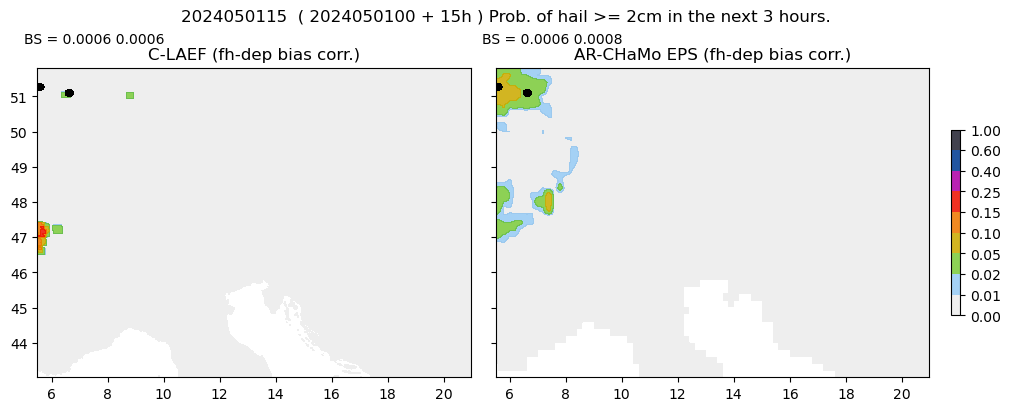

2024050215
my_obs_flat 0.0 0.00780472007448488 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0026420610338322354 0.33849503470002534
bias_corr_lres * my_lres_fcst_flat 0.0 0.0016787648404167608 0.03862516823390652


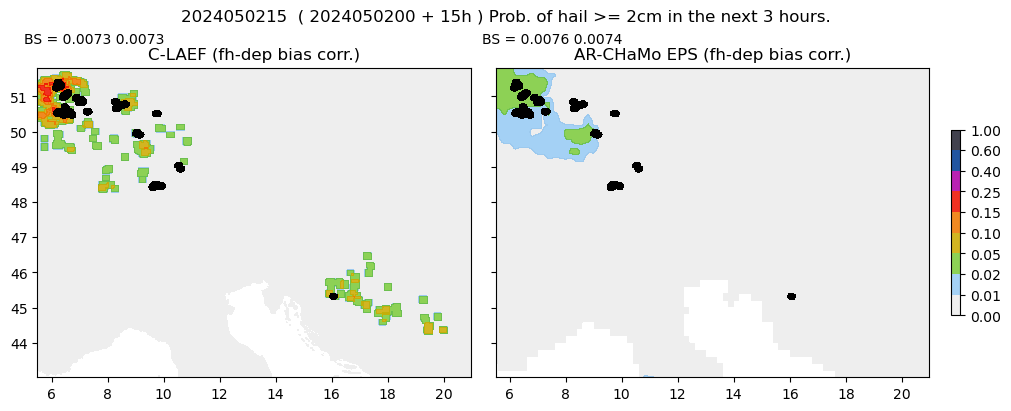

2024050315
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 7.577736772918746e-05 0.05910220921707935
bias_corr_lres * my_lres_fcst_flat 0.0 0.00011206279724839325 0.0025874455909089267


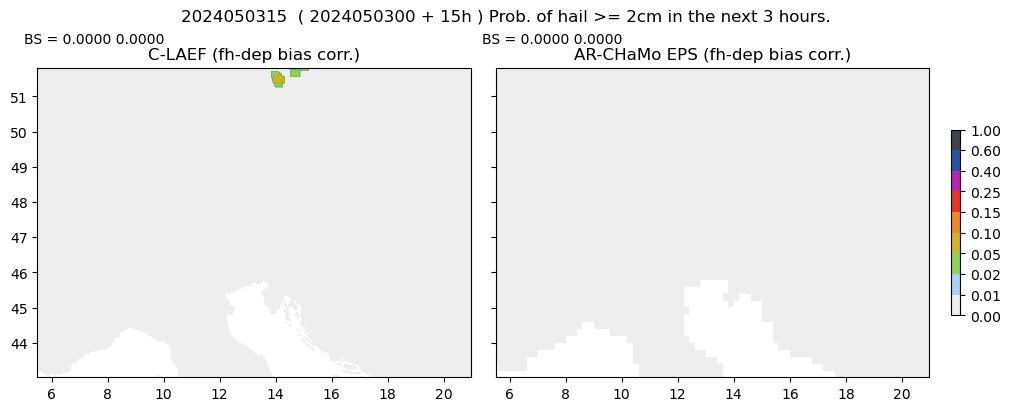

2024050415
my_obs_flat 0.0 0.0008379549042626402 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 8.907393494992176e-05 0.05910220921707935
bias_corr_lres * my_lres_fcst_flat 0.0 0.0005288048524192945 0.01453484343032753


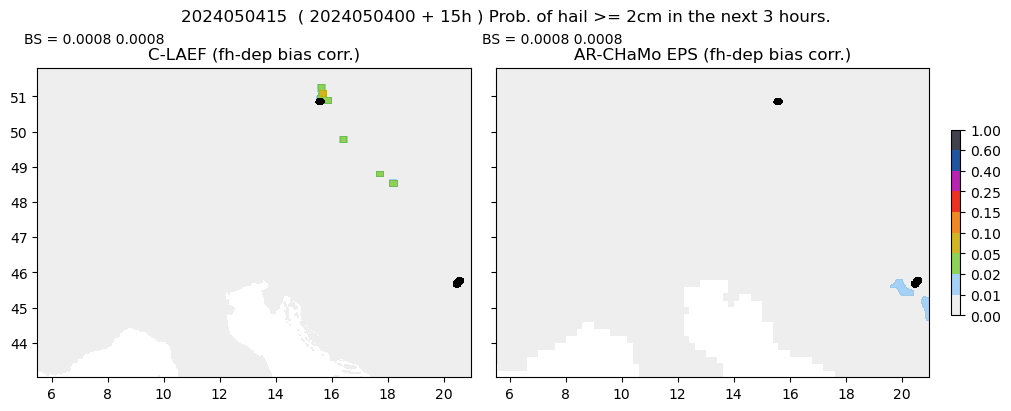

2024050515
my_obs_flat 0.0 0.00032384730599522324 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.00016428484676555004 0.08775782113280464
bias_corr_lres * my_lres_fcst_flat 0.0 0.0004095190554881879 0.020400439433623893


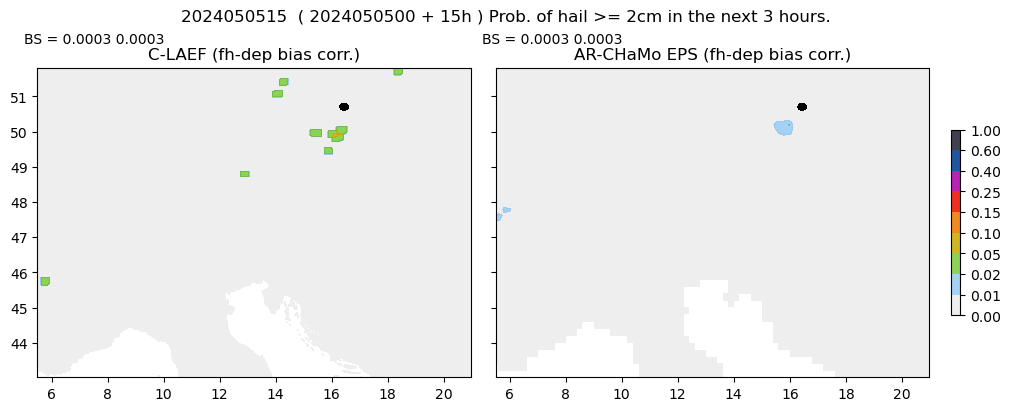

2024050615
my_obs_flat 0.0 0.001238715945431729 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0013823527174393457 0.191634819244939
bias_corr_lres * my_lres_fcst_flat 0.0 0.0008601548302766878 0.026699340284051822


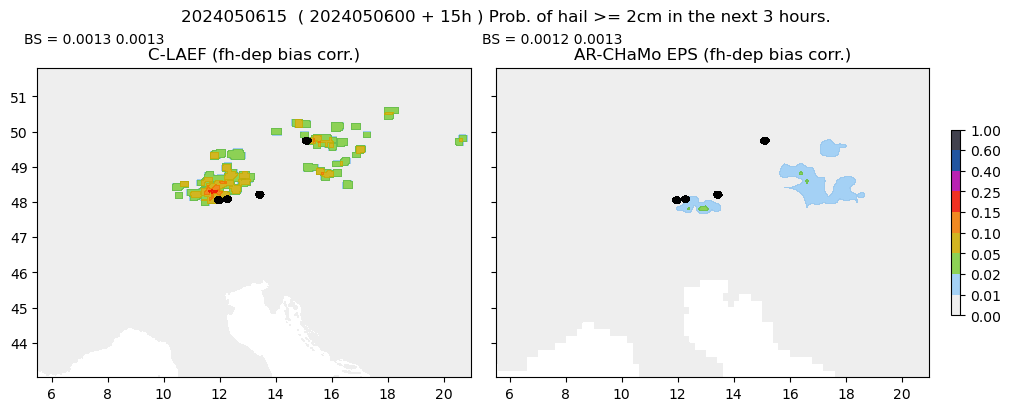

2024050715
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 2.4062865417297016e-05 0.05910220921707935
bias_corr_lres * my_lres_fcst_flat 0.0 0.00031041739430024947 0.019795285979226477


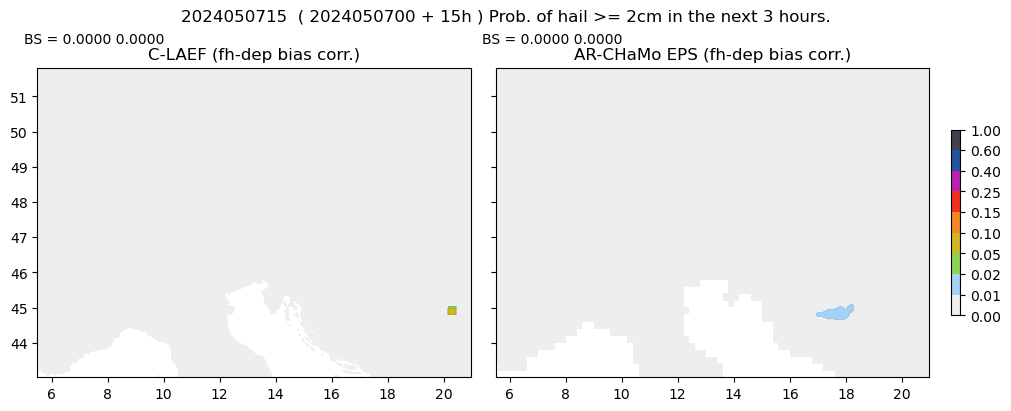

2024050815
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 1.3434316098642243e-05 0.03044659730135407
bias_corr_lres * my_lres_fcst_flat 0.0 0.000170527556643071 0.007578051836117604


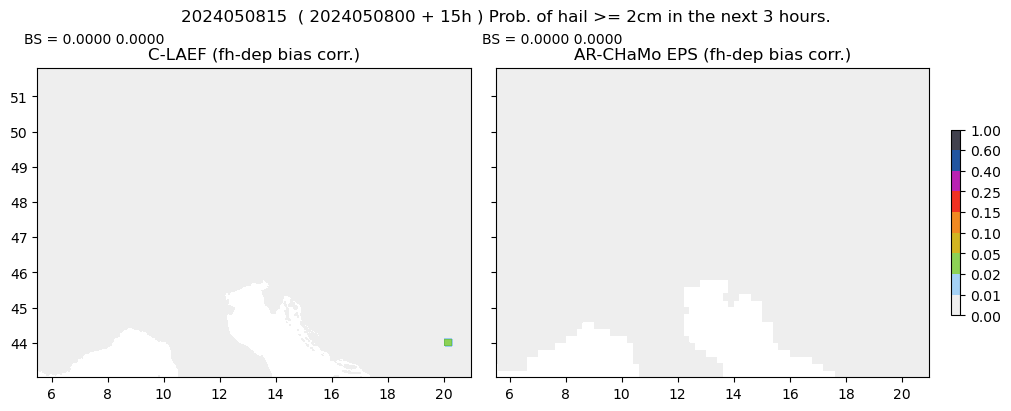

2024050915
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0 0.0
bias_corr_lres * my_lres_fcst_flat 0.0 2.1555406269693624e-05 0.0018187189599048444


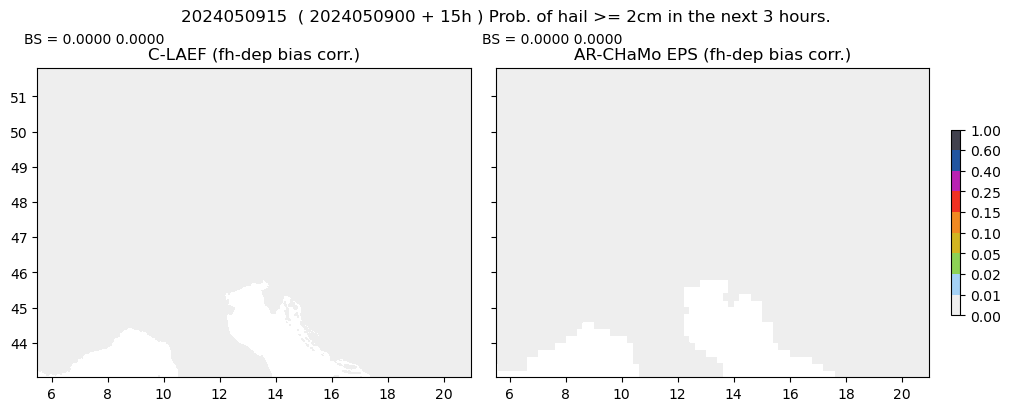

2024051015
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0 0.0
bias_corr_lres * my_lres_fcst_flat 0.0 1.0471283122981936e-05 0.0019107143250599746


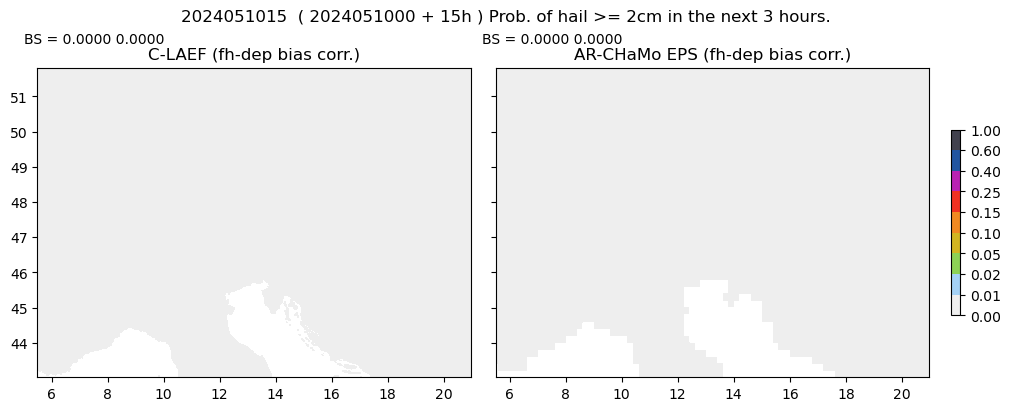

2024051115
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0 0.0
bias_corr_lres * my_lres_fcst_flat 0.0 1.1588432909351067e-05 0.000637083226142218


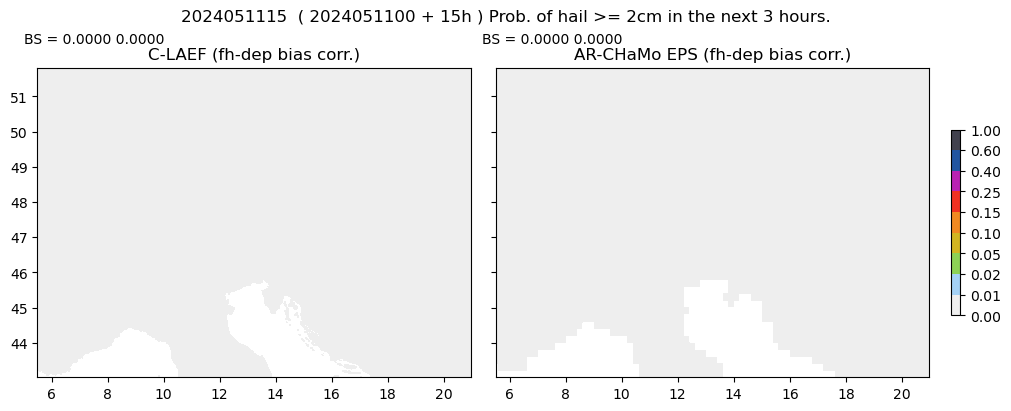

2024051215
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 1.1092554576860568e-05 0.03044659730135407
bias_corr_lres * my_lres_fcst_flat 0.0 0.00010926643970996564 0.00463537831080157


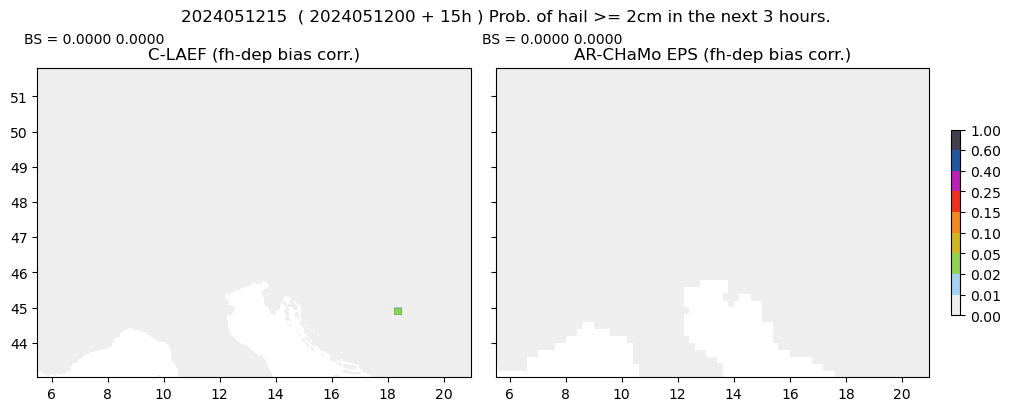

2024051315
my_obs_flat 0.0 0.0002914625753957009 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0001282894387005143 0.11304217369931503
bias_corr_lres * my_lres_fcst_flat 0.0 0.0003041715804566102 0.013356864359168759


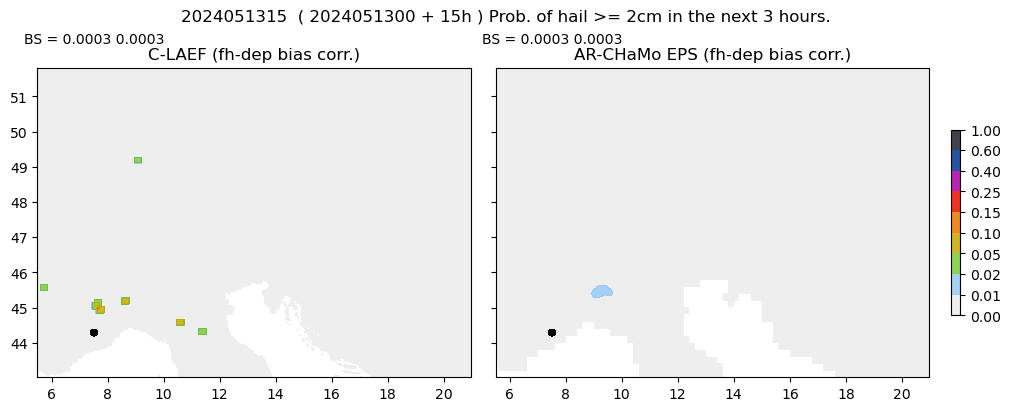

2024051415
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0 0.0
bias_corr_lres * my_lres_fcst_flat 7.828983663762932e-11 0.00016269319831980662 0.017050119030796815


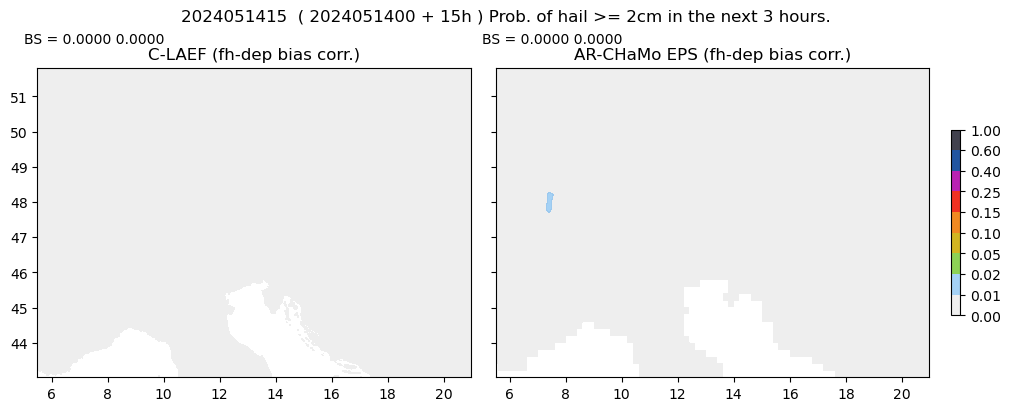

2024051515
my_obs_flat 0.0 0.0011415617536331619 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0008025776146051621 0.22208126229195774
bias_corr_lres * my_lres_fcst_flat 0.0 0.0009281926014735847 0.041655563580505206


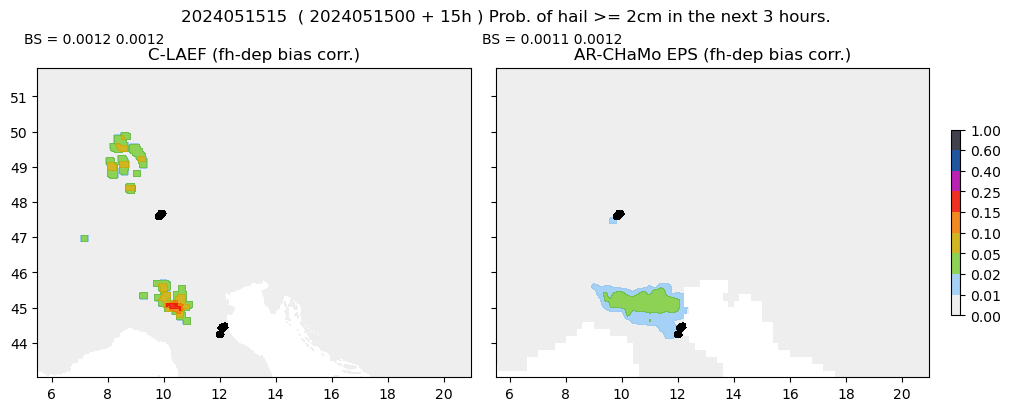

2024051615
my_obs_flat 0.0 0.006201675909808526 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.001935616518372015 0.3317506649495718
bias_corr_lres * my_lres_fcst_flat 0.0 0.0035660519917641346 0.07051128973715622


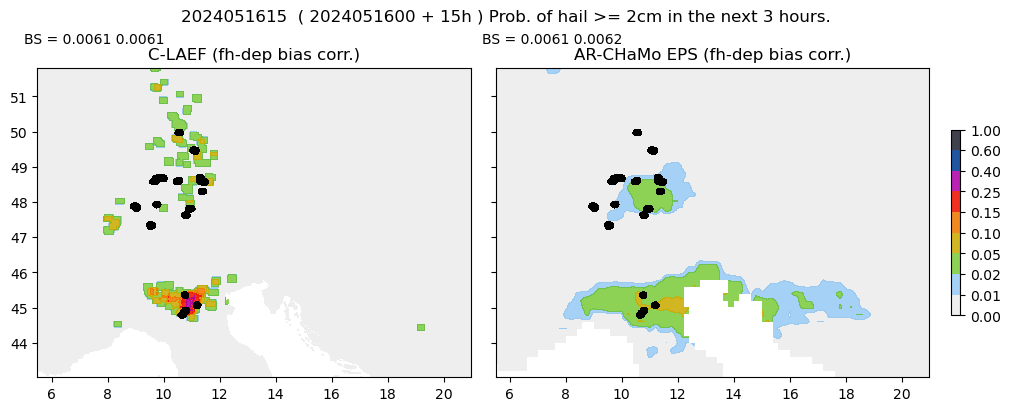

2024051715
my_obs_flat 0.0 0.0006638869772902077 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 3.0566150389571346e-05 0.03044659730135407
bias_corr_lres * my_lres_fcst_flat 0.0 0.0006458592621117546 0.0294260281281086


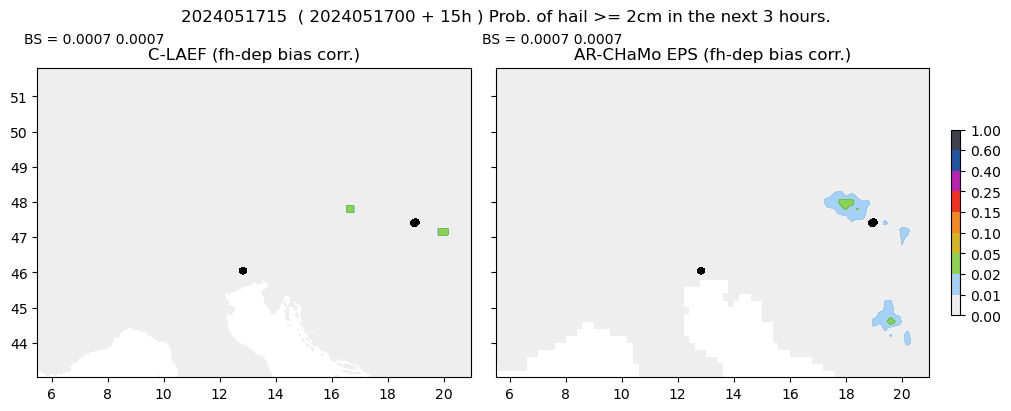

2024051815
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0001095625315324702 0.05910220921707935
bias_corr_lres * my_lres_fcst_flat 0.0 0.0003449268852327764 0.031183692525217226


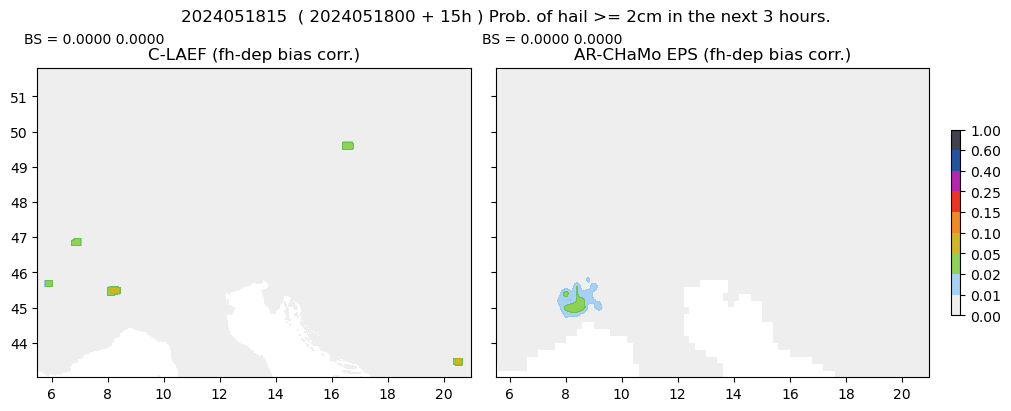

2024051915
my_obs_flat 0.0 0.0032668096992268148 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 8.245465568799689e-05 0.03044659730135407
bias_corr_lres * my_lres_fcst_flat 7.769067974084456e-08 0.0010488817991497566 0.012666828957357127


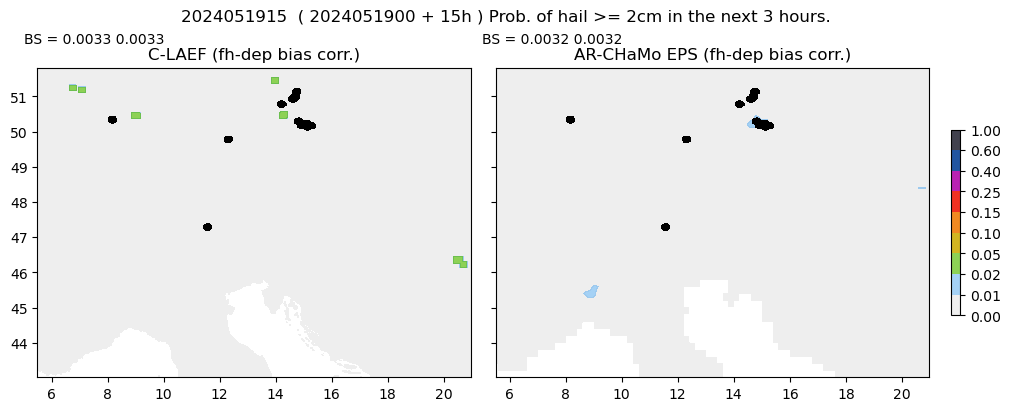

2024052015
my_obs_flat 0.0 0.0002995587580455815 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0001355829121274356 0.05910220921707935
bias_corr_lres * my_lres_fcst_flat 4.793255307731811e-10 0.0016106015914834817 0.03252116831797495


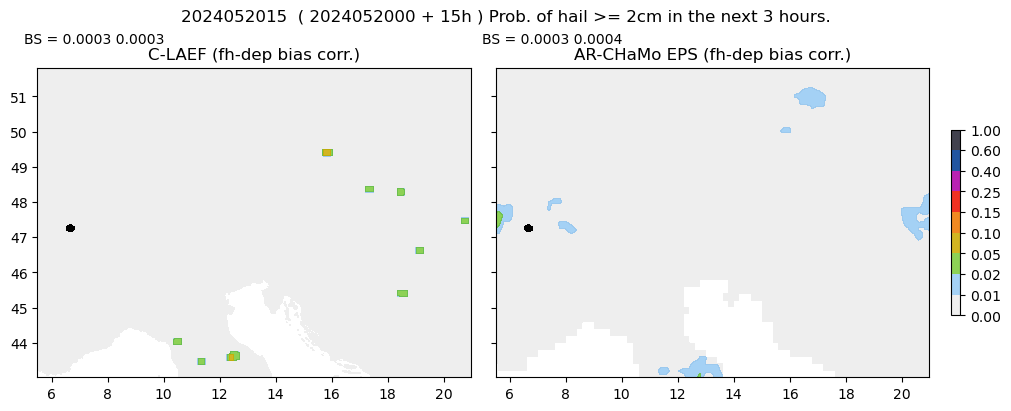

2024052115
my_obs_flat 0.0 0.0008581953608873416 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.009009082940575076 0.35461467444236106
bias_corr_lres * my_lres_fcst_flat 0.0 0.003023578485461348 0.05794680492477022


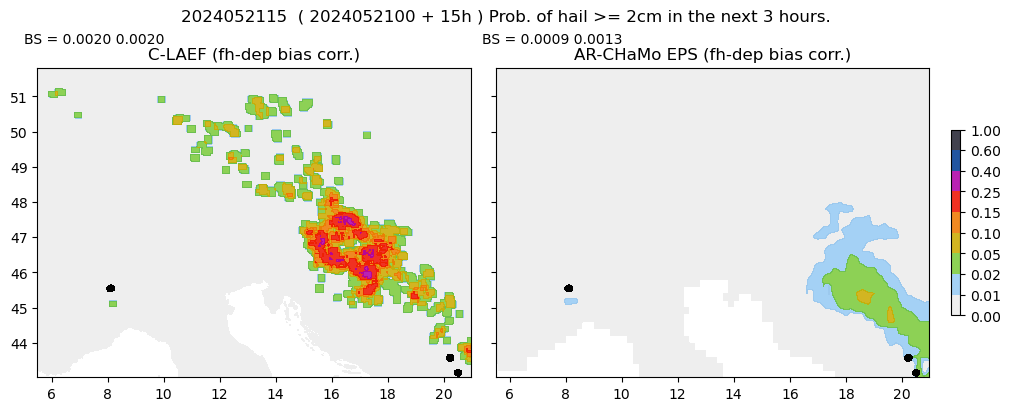

2024052215
my_obs_flat 0.0 0.00028336639274582036 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0005815806150167794 0.09134028551793523
bias_corr_lres * my_lres_fcst_flat 2.2048974402599944e-08 0.0008494617497060472 0.022176635726786822


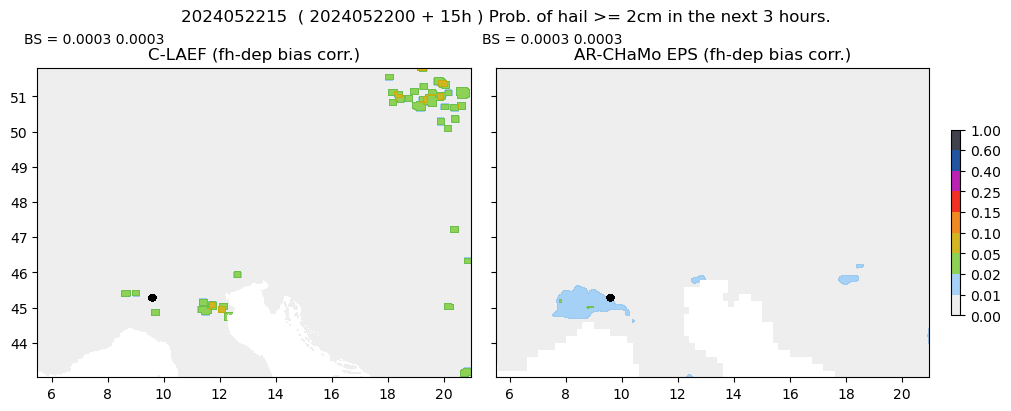

2024052315
my_obs_flat 0.0 0.00028336639274582036 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.00019562592727521307 0.09134028551793523
bias_corr_lres * my_lres_fcst_flat 7.681191626819752e-08 0.0006524559970615538 0.018898466881140163


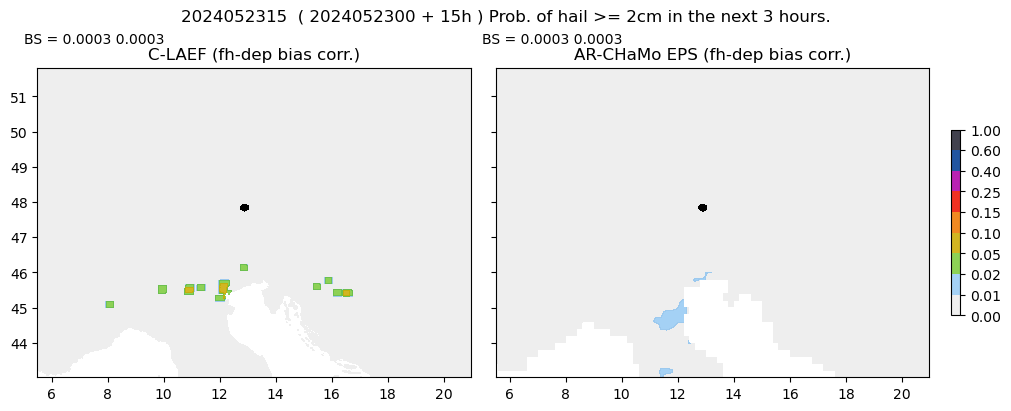

2024052415
my_obs_flat 0.0 0.0007691373517386553 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0013620419181640346 0.1888942750219673
bias_corr_lres * my_lres_fcst_flat 2.2847850287333535e-10 0.0013208718492083236 0.035255689940143276


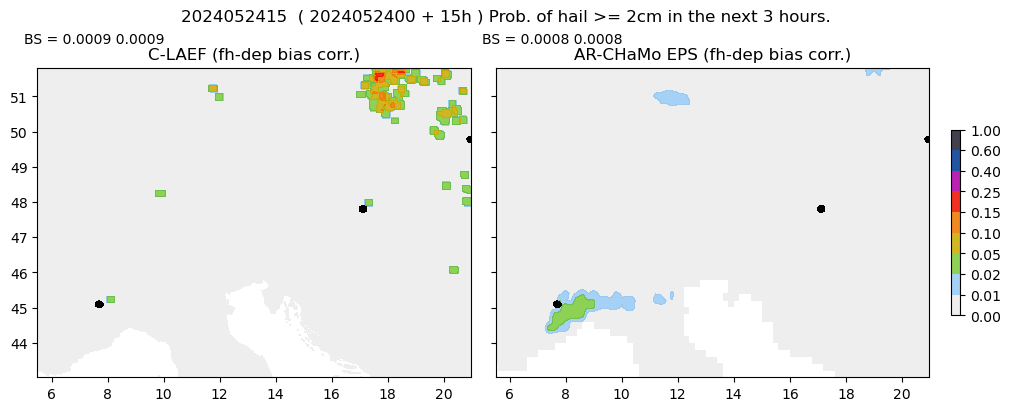

2024052515
my_obs_flat 0.0 0.002853904384082905 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.00037819809800301125 0.05910220921707935
bias_corr_lres * my_lres_fcst_flat 0.0 0.0017607770706005157 0.02397938461879131


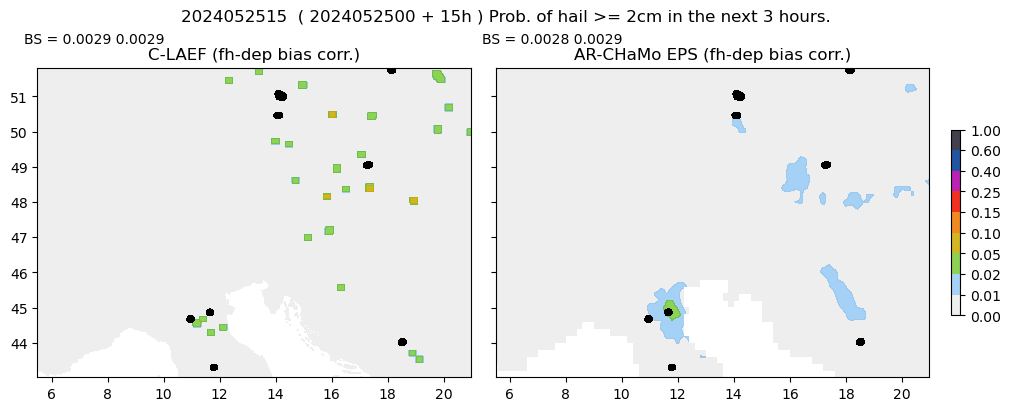

2024052615
my_obs_flat 0.0 0.00032789539732016356 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.00021477292439201002 0.08775738922066575
bias_corr_lres * my_lres_fcst_flat 0.0 0.0007305314580159126 0.0308151778968931


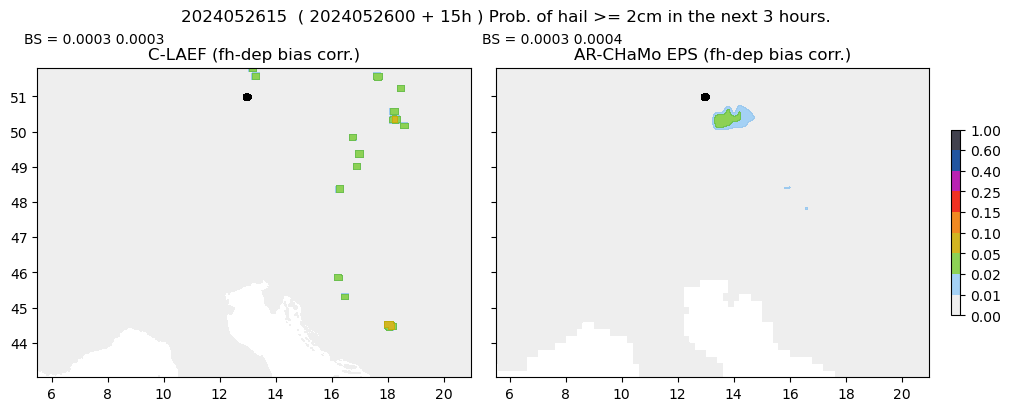

2024052715
my_obs_flat 0.0 0.0019309395619965186 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.00031643156331788983 0.08775738922066575
bias_corr_lres * my_lres_fcst_flat 0.0 0.0007818835481327045 0.03119276209381347


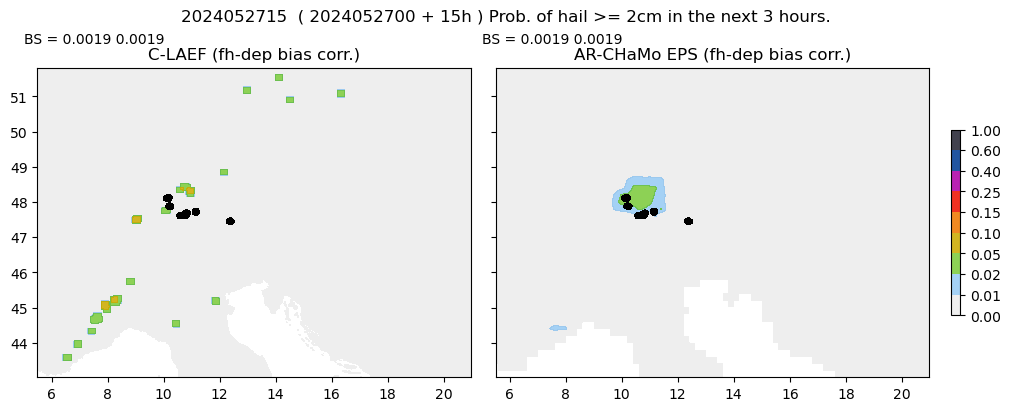

2024052815
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.00025009445850264375 0.08775738922066575
bias_corr_lres * my_lres_fcst_flat 0.0 0.0002455167882822055 0.014769292736297604


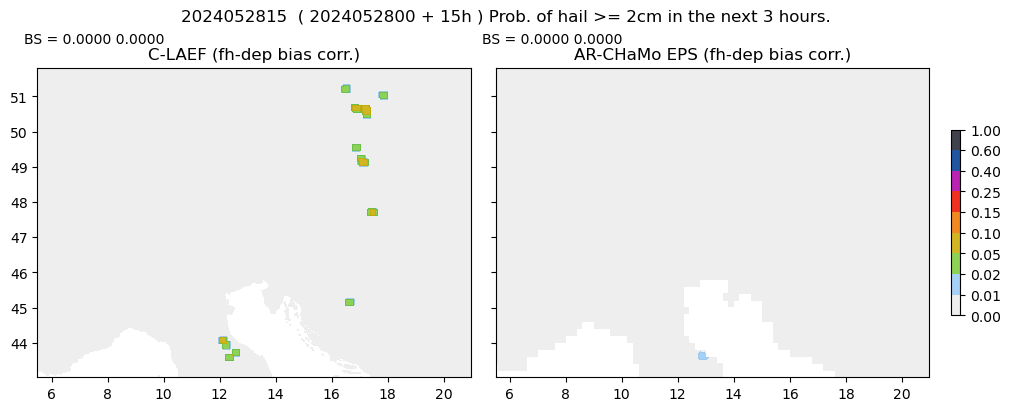

2024052915
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 4.128895314720323e-05 0.03044659730135407
bias_corr_lres * my_lres_fcst_flat 1.5857686301858754e-08 0.0002958057132735696 0.008622080336620137


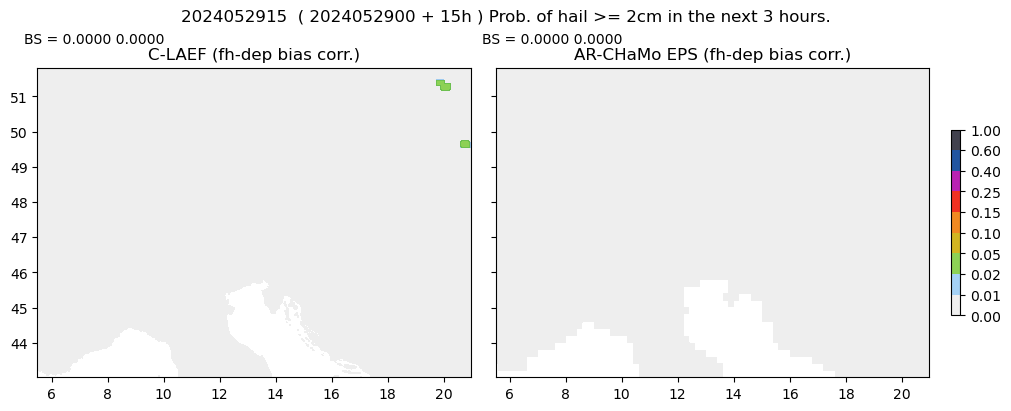

2024053015
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0002449647053857069 0.08775782113280464
bias_corr_lres * my_lres_fcst_flat 6.438460300515051e-08 0.0008862872218330455 0.012067263338279535


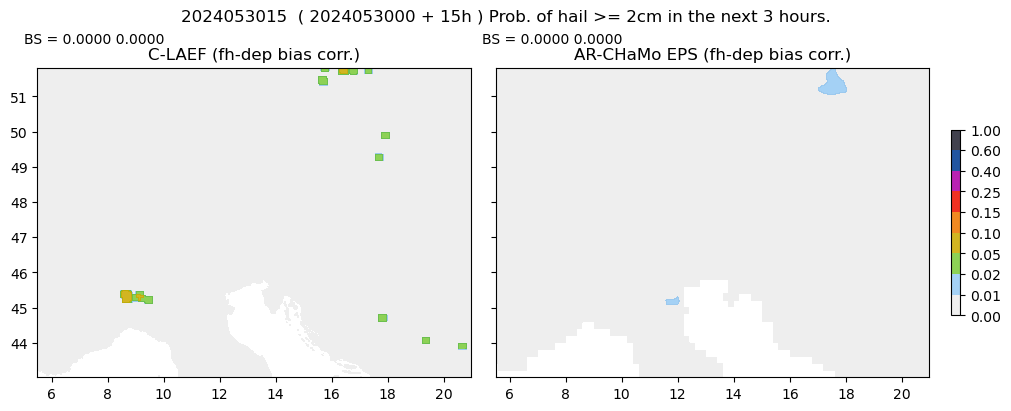

2024053115
my_obs_flat 0.0 0.0018580739181475933 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0016622754409804992 0.14001187828262932
bias_corr_lres * my_lres_fcst_flat 0.0 0.0012602237025267015 0.026620477549613285


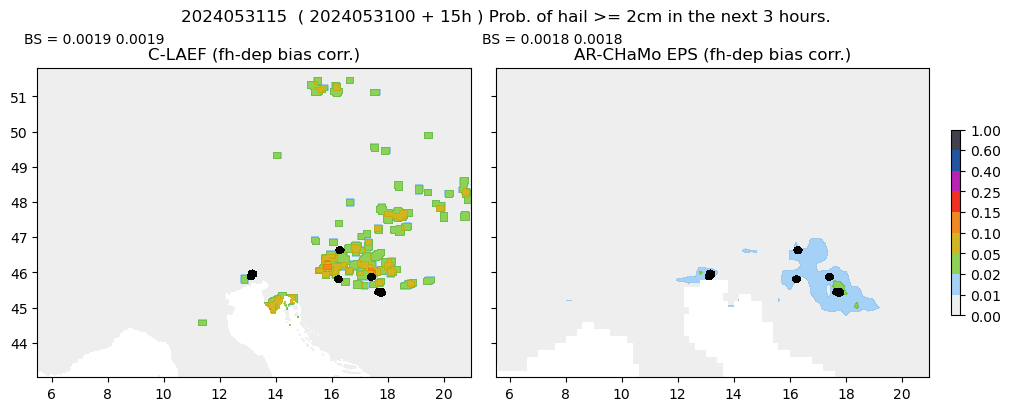

2024060115
my_obs_flat 0.0 0.001016070922560013 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0002758400709323911 0.06089319460270814
bias_corr_lres * my_lres_fcst_flat 0.0 0.0007444230957189303 0.013220597229516462


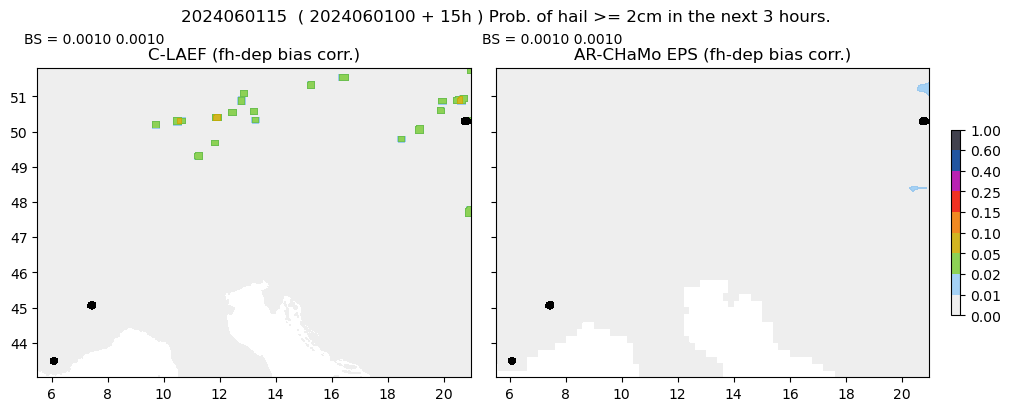

2024060215
my_obs_flat 0.0 0.00027931830142088003 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0006832839355595253 0.08775738922066575
bias_corr_lres * my_lres_fcst_flat 0.0 0.0009047393876872892 0.018556803528497763


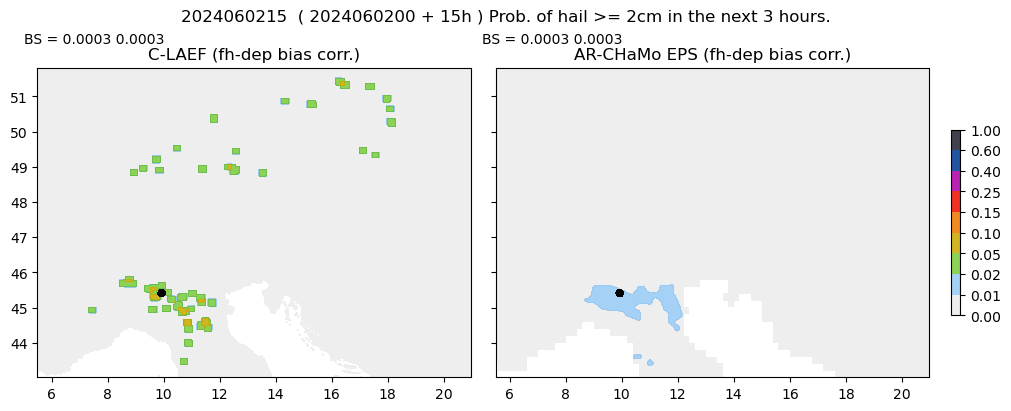

2024060315
my_obs_flat 0.0 0.0013399182285552362 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0036652229601370646 0.27580980578220826
bias_corr_lres * my_lres_fcst_flat 0.0 0.0027824832920965432 0.06331273428087927


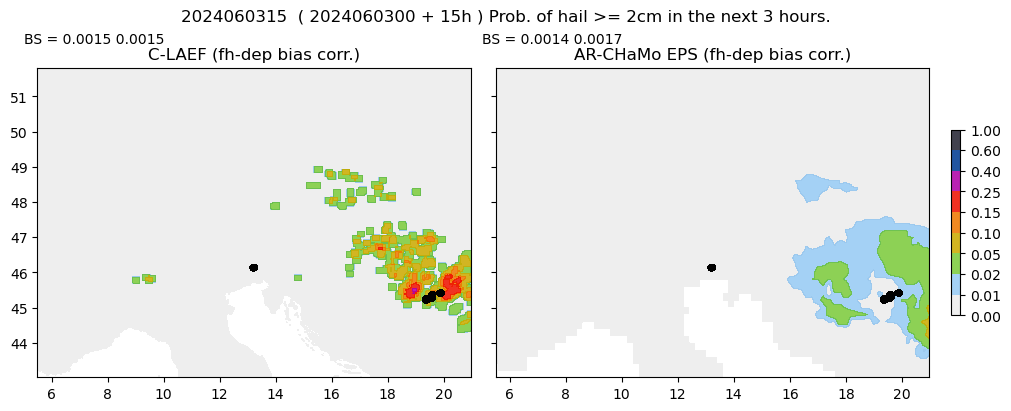

2024060415
my_obs_flat 0.0 0.00028336639274582036 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 8.562291797045402e-05 0.05910220921707935
bias_corr_lres * my_lres_fcst_flat 0.0 0.0003827950209726703 0.012376045741908702


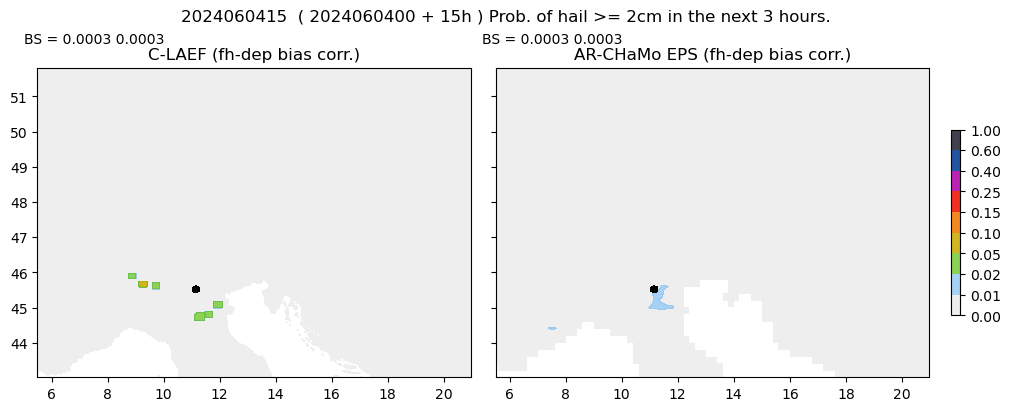

2024060515
my_obs_flat 0.0 0.0005910213334412825 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0004539599326459635 0.1130413715767714
bias_corr_lres * my_lres_fcst_flat 0.0 0.00044005466458430897 0.011430552825575643


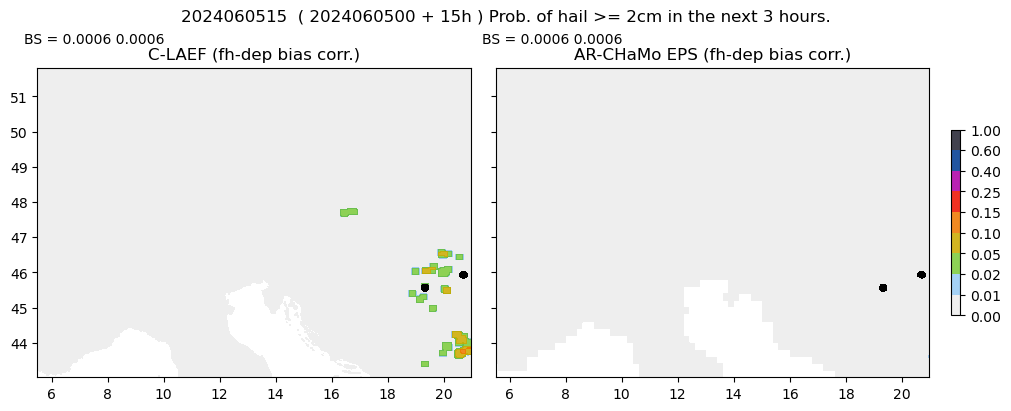

2024060615
my_obs_flat 0.0 0.0014249281463789823 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0005752165699498261 0.08775738922066575
bias_corr_lres * my_lres_fcst_flat 0.0 0.0013252882846584066 0.033038473324505935


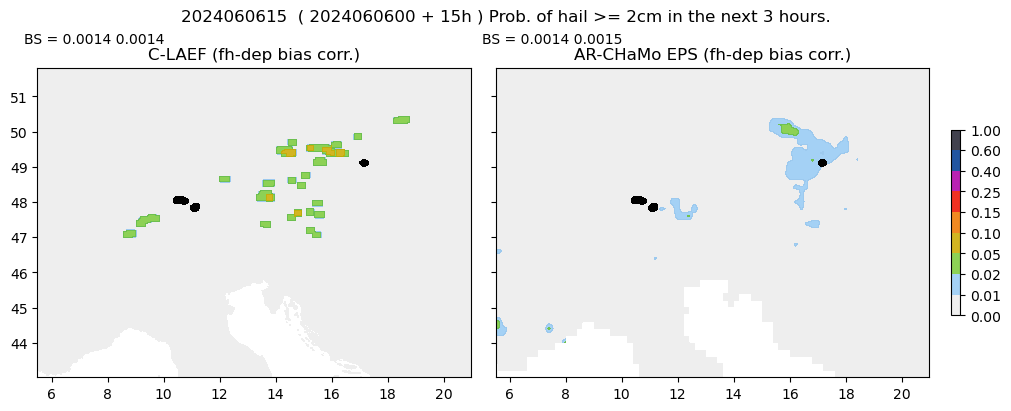

2024060715
my_obs_flat 0.0 0.0026676921831356513 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.00041313689015986757 0.16835099115315166
bias_corr_lres * my_lres_fcst_flat 0.0 0.0023107977236326814 0.046830325739069506


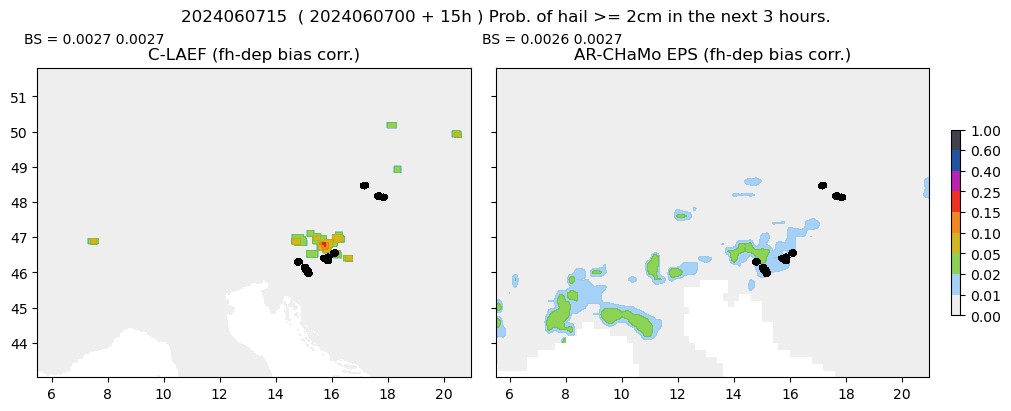

2024060815
my_obs_flat 0.0 0.0023721815164150103 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0022553268532193808 0.23820093288516048
bias_corr_lres * my_lres_fcst_flat 0.0 0.0031440197367071173 0.07347782716018697


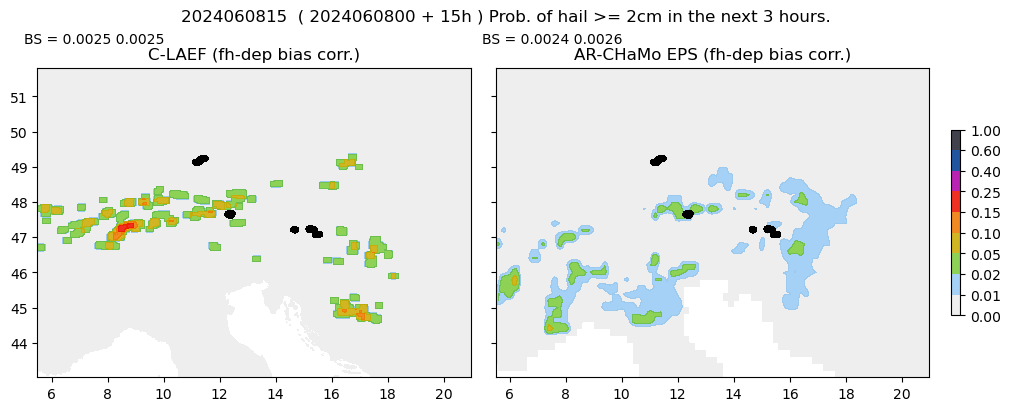

2024060915
my_obs_flat 0.0 0.007703517791361373 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.004946461460353553 0.29045431131590976
bias_corr_lres * my_lres_fcst_flat 0.0 0.0052106922210995435 0.10515319754498818


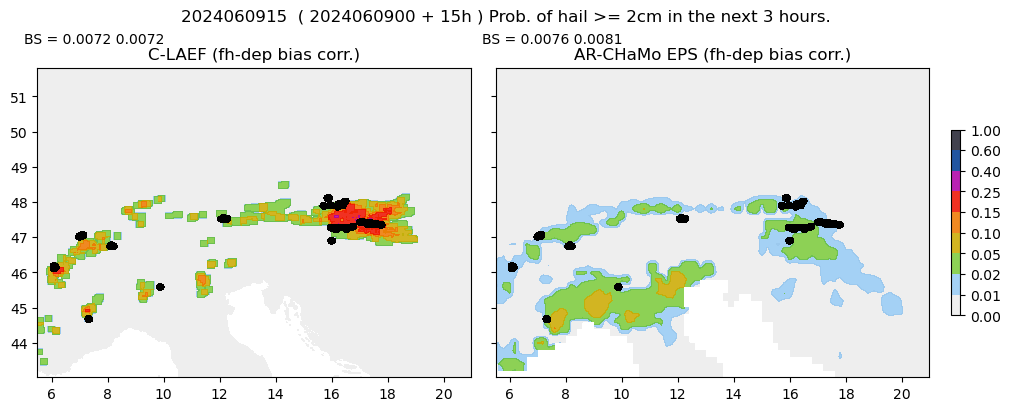

2024061015
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.002177770369575716 0.16835099115315166
bias_corr_lres * my_lres_fcst_flat 0.0 0.0010968184188586614 0.027896506164548137


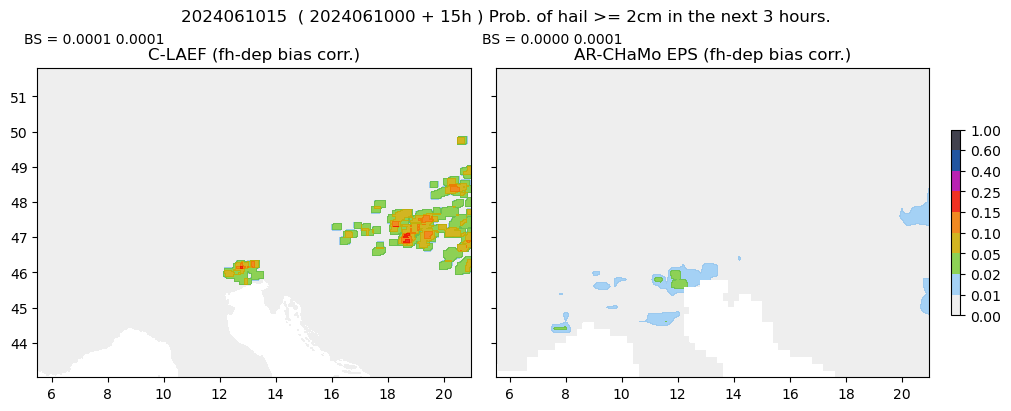

2024061115
my_obs_flat 0.0 0.0014006395984293406 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 4.942349317023431e-05 0.03044659730135407
bias_corr_lres * my_lres_fcst_flat 0.0 0.0006942063603202911 0.025867012835773705


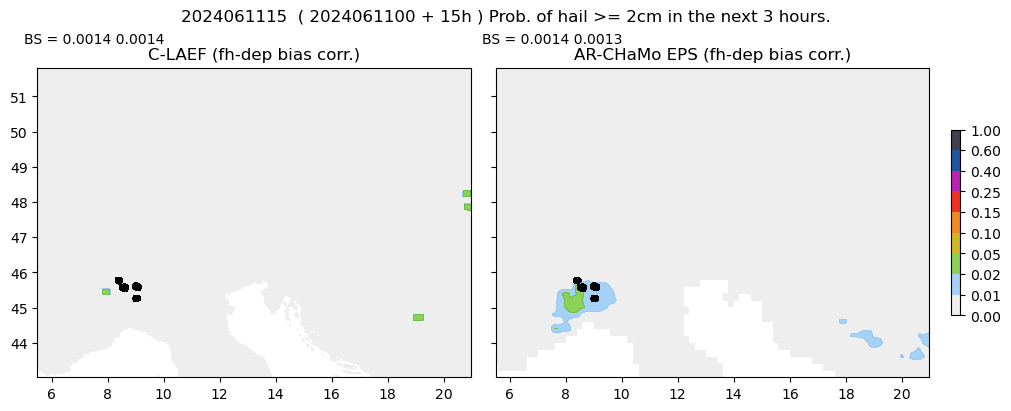

2024061215
my_obs_flat 0.0 0.000850099178237461 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 9.364811281938054e-05 0.08775782113280464
bias_corr_lres * my_lres_fcst_flat 0.0 0.0005053071525339277 0.020938113049473992


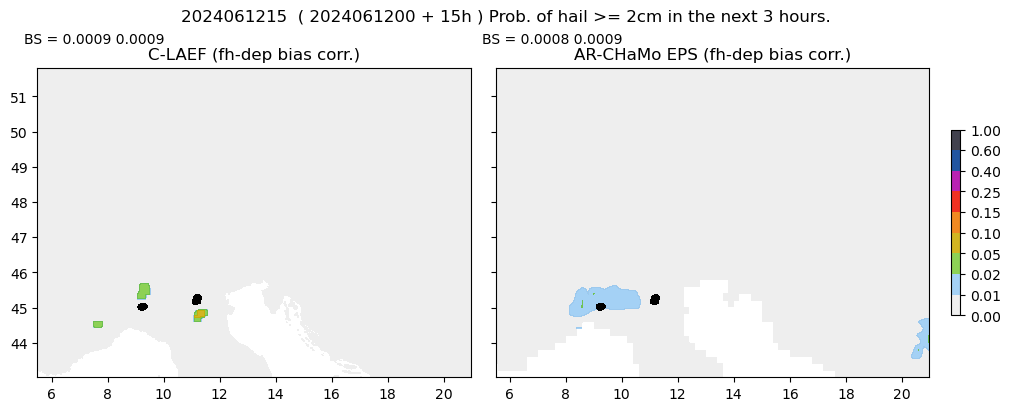

2024061315
my_obs_flat 0.0 0.0012346678541067886 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0005417392298112835 0.287504351407312
bias_corr_lres * my_lres_fcst_flat 0.0 0.0017165585509134097 0.07617037296580362


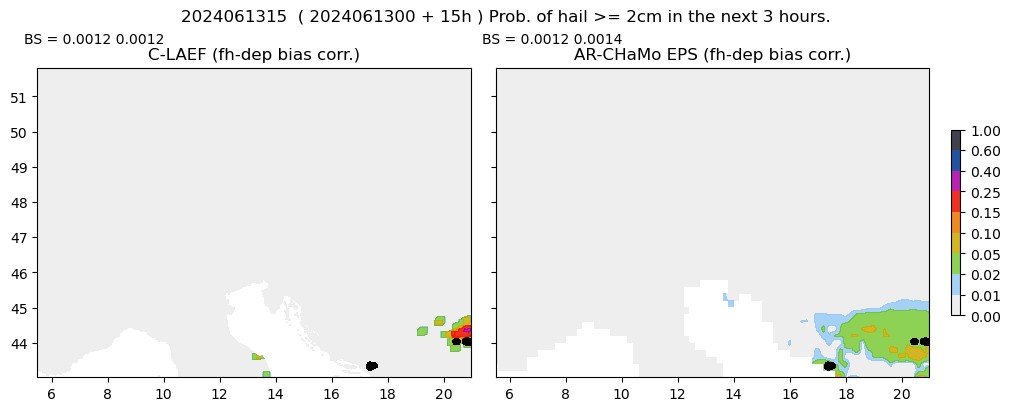

2024061415
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0 0.0
bias_corr_lres * my_lres_fcst_flat 0.0 1.284583287689231e-05 0.0008410317656547864


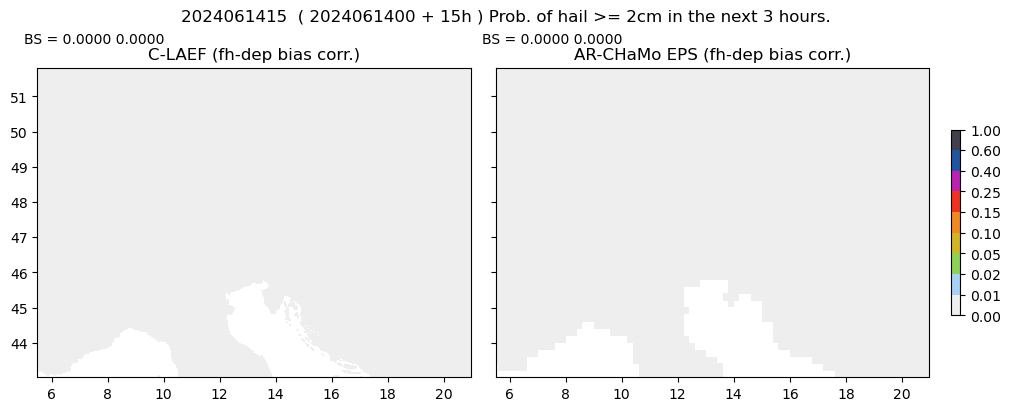

2024061515
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0002838153064344506 0.16361060117453227
bias_corr_lres * my_lres_fcst_flat 0.0 0.0003953634015246862 0.05221458238785779


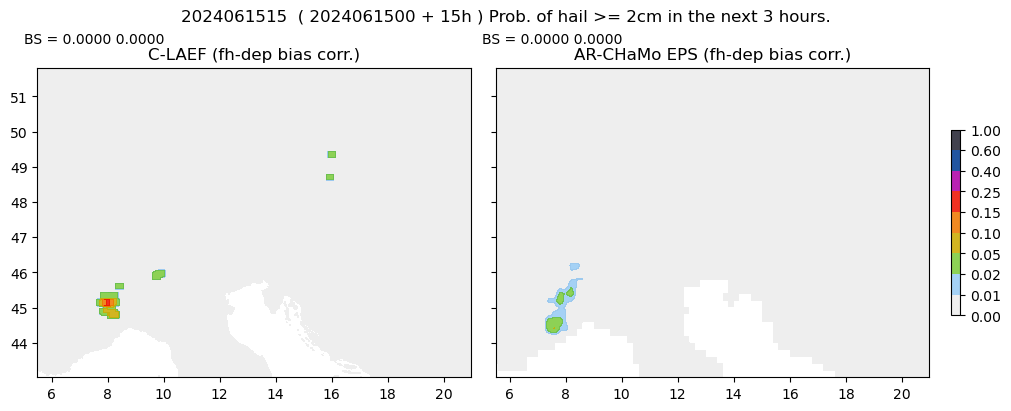

2024061615
my_obs_flat 0.0 0.0020483342104197872 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 2.475161979780705e-05 0.05910220921707935
bias_corr_lres * my_lres_fcst_flat 0.0 0.00016845258801223085 0.005446372981782763


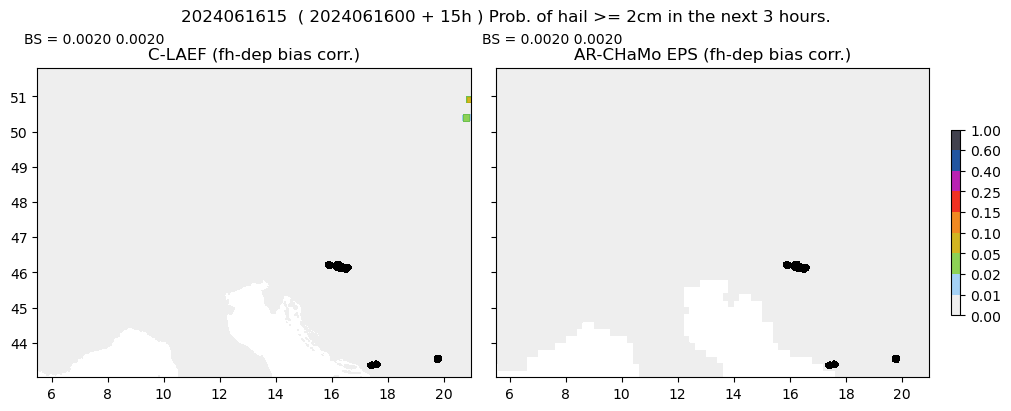

2024061715
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 7.976488881758068e-05 0.05910220921707935
bias_corr_lres * my_lres_fcst_flat 0.0 0.0004822006634969407 0.020379826950937475


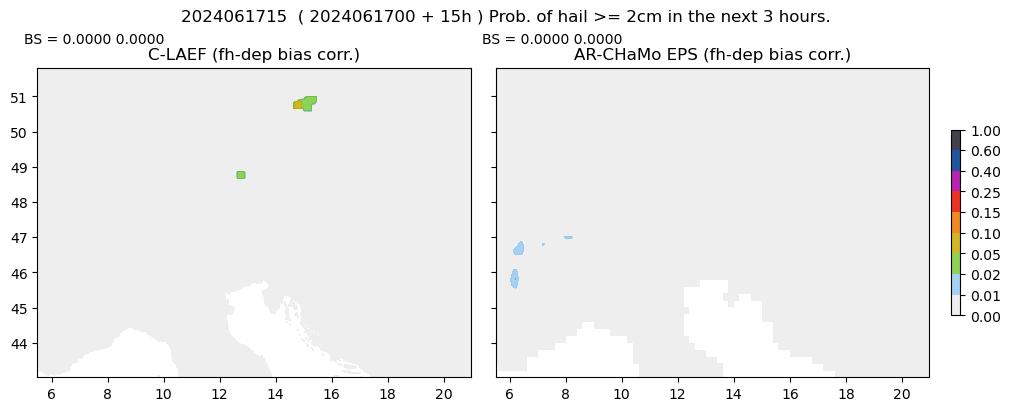

2024061815
my_obs_flat 0.0 0.007849249079059224 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.005430460584403303 0.29635296624755564
bias_corr_lres * my_lres_fcst_flat 0.0 0.0033743722319089626 0.041228443348079284


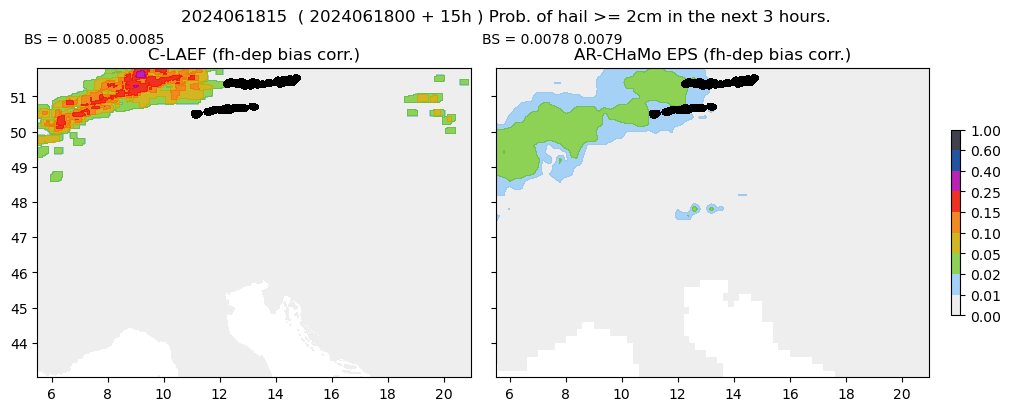

2024061915
my_obs_flat 0.0 0.0013034854066307736 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0014975978887661536 0.14148756780687063
bias_corr_lres * my_lres_fcst_flat 0.0 0.003451102816534607 0.08980820385965028


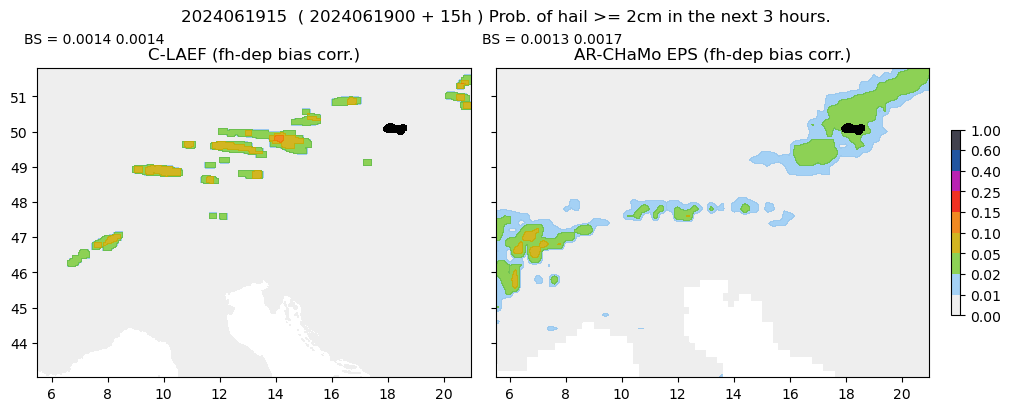

2024062015
my_obs_flat 0.0 0.0004695785936930737 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0069135892045832925 0.35830061263562213
bias_corr_lres * my_lres_fcst_flat 0.0 0.002667920839664515 0.06840951577622839


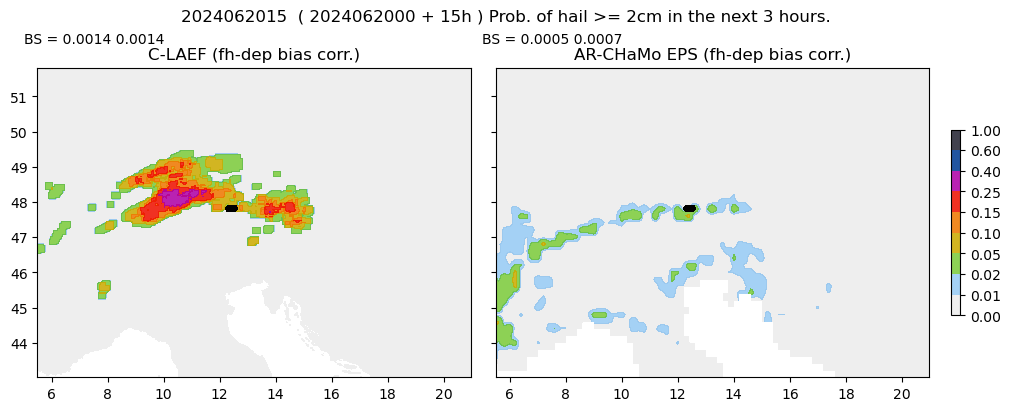

2024062115
my_obs_flat 0.0 0.0089017528235437 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.016420773206787132 0.40254871552817156
bias_corr_lres * my_lres_fcst_flat 8.399684618337164e-07 0.015752334001475268 0.12250867707566283


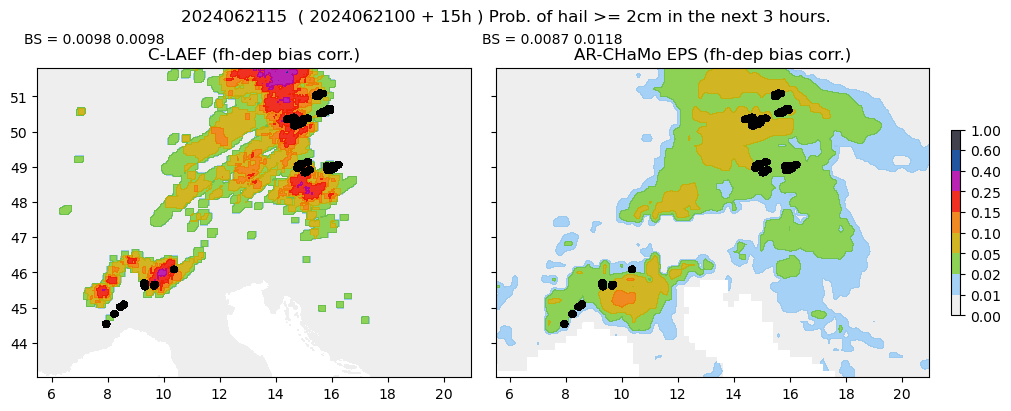

2024062215
my_obs_flat 0.0 0.006877707161073554 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0030783714448218186 0.2900340916556398
bias_corr_lres * my_lres_fcst_flat 0.0 0.004266902686150972 0.0791567268131538


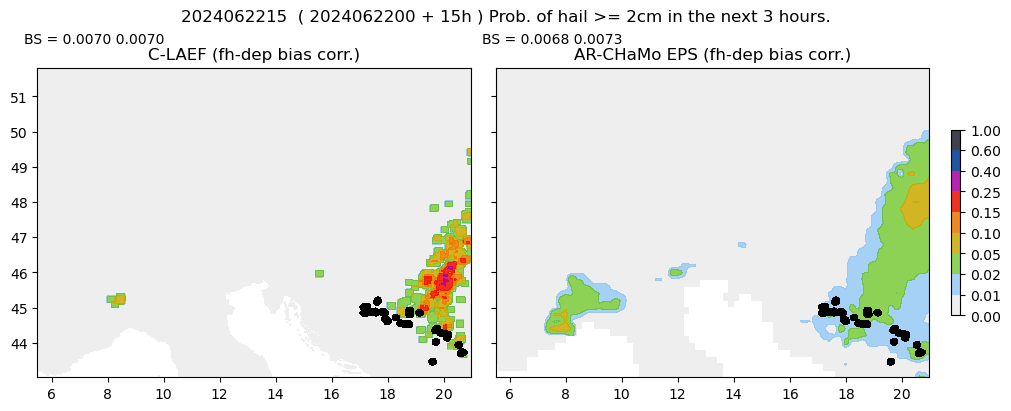

2024062315
my_obs_flat 0.0 0.00028741448407076063 1.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0009573884575766939 0.2614832492844617
bias_corr_lres * my_lres_fcst_flat 0.0 0.0022136305435013076 0.045561416089198385


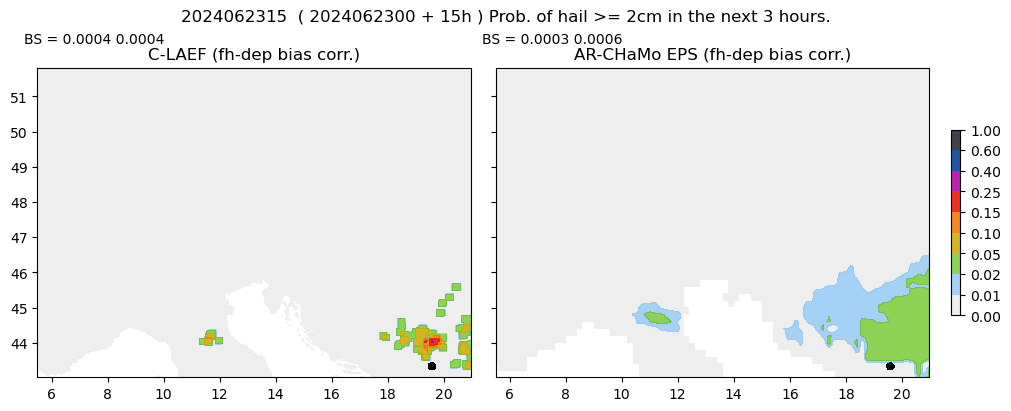

2024062415
my_obs_flat 0.0 0.0 0.0
bias_corr_hres * my_hres_fcst_flat 0.0 0.0012879952857006338 0.22998207679428107
bias_corr_lres * my_lres_fcst_flat 0.0 0.0010177823709339848 0.04403944070389167


KeyboardInterrupt: 

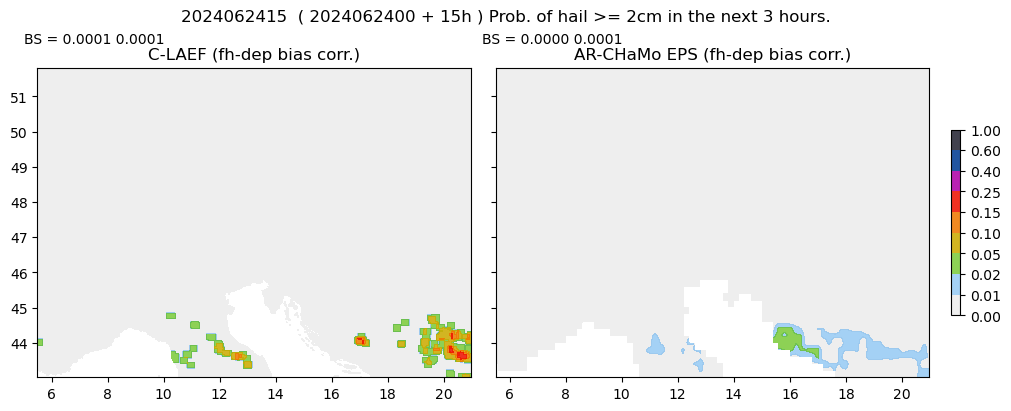

In [51]:
#Plot forecasts

def MinMeanMax(paramname, param):
    print(paramname, np.nanmin(param), np.nanmean(param), np.nanmax(param))



print(my_temp_hres_fcst.shape)
print(my_temp_lres_fcst.shape)

print(np.nanmax(my_temp_hres_fcst))
print(np.nanmax(my_temp_lres_fcst))

for i in range(0, my_temp_obs.shape[2] - 1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained', sharey = True)
    print(AddHours(hres_fcst_dtgs[i], fh))

    my_map2 = axs[0].contourf(hres_lons, hres_lats, bias_corr_hres * my_temp_hres_fcst[:,:,i].reshape(hres_nj, hres_ni), levels, colors=colors)
    axs[0].set_title('C-LAEF (fh-dep bias corr.)')
    my_map3 = axs[1].contourf(hres_lons, hres_lats, bias_corr_lres * my_temp_lres_fcst[:,:,i].reshape(hres_nj, hres_ni), levels, colors=colors)
    axs[1].set_title('AR-CHaMo EPS (fh-dep bias corr.)')

    my_map  = axs[0].contourf(hres_lons, hres_lats, my_temp_obs[:,:,i].reshape(hres_nj, hres_ni), obs_levels, colors=obs_colors)
    my_map  = axs[1].contourf(hres_lons, hres_lats, my_temp_obs[:,:,i].reshape(hres_nj, hres_ni), obs_levels, colors=obs_colors)

    #print('my_temp_obs[:,:,i].shape', my_temp_obs[:,:,i].shape)
    #print('my_temp_hres_fcst[:,:,i].shape', my_temp_hres_fcst[:,:,i].shape)
    #print('my_temp_lres_fcst[:,:,i].shape', my_temp_lres_fcst[:,:,i].shape)
    
    my_obs_flat = np.copy(my_temp_obs[:,:,i].flatten())    
    my_hres_fcst_flat = np.copy(my_temp_hres_fcst[:,:,i].flatten())
    my_lres_fcst_flat = np.copy(my_temp_lres_fcst[:,:,i].flatten())
    
    #print(np.count_nonzero(np.isnan(my_obs_flat)))
    #print(np.count_nonzero(np.isnan(my_hres_fcst_flat)))
    #print(np.count_nonzero(np.isnan(my_lres_fcst_flat)))

    notnan = ~np.isnan(my_obs_flat + my_hres_fcst_flat + my_lres_fcst_flat)
    my_hres_fcst_flat = my_hres_fcst_flat[notnan]    
    my_lres_fcst_flat = my_lres_fcst_flat[notnan]
    my_obs_flat = my_obs_flat[notnan]

    #print('my_obs_flat.shape', my_obs_flat.shape)
    #print('my_hres_fcst_flat.shape', my_hres_fcst_flat.shape)
    
    bs_hres = brier_score_loss(my_obs_flat, bias_corr_hres * my_hres_fcst_flat)
    bs_lres = brier_score_loss(my_obs_flat, bias_corr_lres * my_lres_fcst_flat)    

    bs_hres2 = np.mean((my_obs_flat - bias_corr_hres * my_hres_fcst_flat)**2)
    bs_lres2 = np.mean((my_obs_flat - bias_corr_hres * my_lres_fcst_flat)**2)    
    
    MinMeanMax('my_obs_flat', my_obs_flat)
    MinMeanMax('bias_corr_hres * my_hres_fcst_flat', bias_corr_hres * my_hres_fcst_flat)
    MinMeanMax('bias_corr_lres * my_lres_fcst_flat', bias_corr_lres * my_lres_fcst_flat)

    axs[0].text(5, 52.5, 'BS = ' + f'{bs_hres:.4f} ' + f'{bs_hres2:.4f}')
    axs[1].text(5, 52.5, 'BS = ' + f'{bs_lres:.4f} ' + f'{bs_lres2:.4f}')
    
    fig.colorbar(my_map2, ax=axs[1], shrink=0.6)
    fig.suptitle(AddHours(hres_fcst_dtgs[i], fh) + '  ( ' + hres_fcst_dtgs[i] + ' + ' + str(fh) + 'h ) Prob. of hail >= 2cm in the next 3 hours.')
    
    plt.savefig('web/' + hazardtype + '_' + hres_fcst_dtgs[i] + '_3h_combi_bs_score.png', bbox_inches='tight')
    plt.show()

print(observations1d_hres_3h[15].shape)


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

my_map = ax.pcolor(hres_lons, hres_lats, np.sum(my_temp_obs, axis=2).reshape(hres_nj, hres_ni), cmap='inferno')
plt.colorbar(my_map)
plt.show()

print(my_temp_obs.shape)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

my_map = ax.pcolor(hres_lons, hres_lats, np.sum(my_temp_fcst, axis=2).reshape(hres_nj, hres_ni), cmap='inferno')
plt.colorbar(my_map)
plt.show()


In [ ]:
corr = 0.1
prob_trues_hres, prob_preds_hres = CalcReliability(observations1d_hres_3h, forecast1d_hres_3h, forecasthours_3h, corr)

 . 20250405 09:10:49U Plotting reliability 


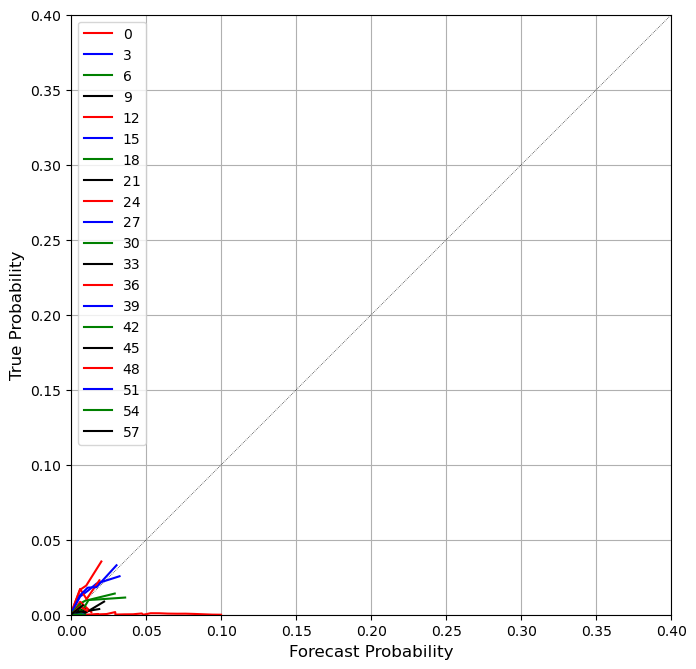

In [64]:
DrawReliabilityDiurnalCycle(prob_trues_hres, prob_preds_hres, forecasthours_3h, label='hres3h')

In [76]:
def DrawReliabilityPerForecastHour(prob_trues, prob_preds, forecast_hours, label):
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0,0,1,1])
    diagonal = ax.plot([0,1],[0,1],'k:', linewidth=0.5)

    tu.Timestamp('Plotting reliability')
    lines = []

    colorcycle = (cycler(color=['#00bb00', '#00ff00', '#44ff00', '#88ee00', '#dddd00', '#ffbb00', '#ff8800',\
                                '#ff0000', '#ff0044', '#ff0088', '#ff00bb', '#ff00ff', '#8800ff', '#0000ff',\
                                '#0044ff', '#0088ff', '#00bbff', '#00dddd', '#00ffbb', '#00ff88', '#00dd44']))
    ax.set_prop_cycle(colorcycle)
   
    for prob_true, prob_pred, fh in zip(prob_trues, prob_preds, forecast_hours):
        plot, = ax.plot(prob_pred, prob_true, label='+ ' + str(fh) + ' h')
        lines.append(plot)

    ax.legend() #lines[0:4], ['06-12 UTC (morning)', '12-18 UTC (afternoon)', '18-24 UTC (evening)', '00-06 UTC (night)'])
        
    ax.set_xlim([0.0,0.1])
    ax.set_ylim([0.0,0.1])
    ax.set_xlabel("Forecast Probability", fontsize=12)
    ax.set_ylabel("True Probability", fontsize=12)
    ax.grid()
    plt.savefig(hazardtype + '_' + label + '_' + str(corr) + '_reliability_12UTC_new.png', bbox_inches='tight')
        
    return

 . 20250405 09:18:45U Plotting reliability 


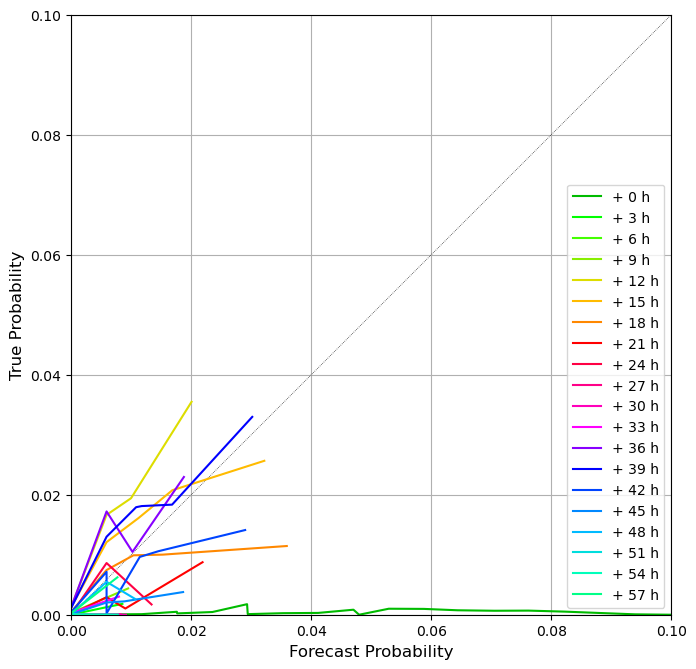

In [77]:
DrawReliabilityPerForecastHour(prob_trues_hres, prob_preds_hres, forecasthours_3h, 'hres3h')

In [51]:
def CalcROCCurve(observations1d, forecast1d, forecast_hours):

    roc_aucs, fprs, tprs, thresholds = [], [], [], []

    tu.Timestamp('Calculating ROC curves')

    for fh in forecast_hours:
        tu.Timestamp(str(fh))
        roc_aucs.append(roc_auc_score(observations1d[fh], forecast1d[fh]))
        fpr, tpr, threshold = roc_curve(observations1d[fh], forecast1d[fh])
        fprs.append(fpr)
        tprs.append(tpr)
        thresholds.append(threshold)
    
    return roc_aucs, fprs, tprs, thresholds

In [80]:
roc_aucs, fprs, tprs, thresholds = CalcROCCurve(observations1d_hres_3h, forecast1d_hres_3h, forecasthours_3h)

 . 20250405 09:21:29U Calculating ROC curves 
 . 20250405 09:21:29U 0 
 . 20250405 09:21:38U 3 
 . 20250405 09:21:44U 6 
 . 20250405 09:21:50U 9 
 . 20250405 09:21:55U 12 
 . 20250405 09:22:01U 15 
 . 20250405 09:22:07U 18 
 . 20250405 09:22:14U 21 
 . 20250405 09:22:20U 24 
 . 20250405 09:22:26U 27 
 . 20250405 09:22:31U 30 
 . 20250405 09:22:37U 33 
 . 20250405 09:22:43U 36 
 . 20250405 09:22:48U 39 
 . 20250405 09:22:54U 42 
 . 20250405 09:23:00U 45 
 . 20250405 09:23:06U 48 
 . 20250405 09:23:12U 51 
 . 20250405 09:23:19U 54 
 . 20250405 09:23:25U 57 


In [82]:
def DrawROCCurve(roc_aucs, fprs, tprs, thresholds, forecast_hours, label):

    tu.Timestamp('Plotting ROC curves')
    
    fig = plt.figure(figsize=(6,6))
    
    ax = fig.add_axes([0,0,1,1])
    diagonal = ax.plot([0,1],[0,1],'k:', linewidth=0.5)
    
    colorcycle = (cycler(color=['#ff0000', '#ff0088', '#ff00ff', '#8800ff', '#0000ff', '#0044ff', '#0088ff', '#00bbbb', '#00bb88', '#00bb00']))
    ax.set_prop_cycle(colorcycle)

    
    for roc_auc, fpr, tpr, threshold, fh in zip(roc_aucs, fprs, tprs, thresholds, forecast_hours):
        curve = ax.plot(fpr, tpr, label = '+' + str(fh) + 'h  ' + '{:.3f}'.format(roc_auc))
        
        for i, txt in enumerate(threshold):
            ax.annotate('{0:.2f}'.format(txt), (fpr[i], tpr[i]))

    ax.set_xticks(np.arange(0,1.01,0.1))
    ax.set_yticks(np.arange(0,1.01,0.1))
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.0])
    ax.set_xlabel("False Alarm Rate", fontsize=12)
    ax.set_ylabel("Probability Of Detection", fontsize=12)
    ax.grid()
    
    legend = ax.legend(title='time, AUC', loc='lower right')
    
    plt.savefig(hazardtype + '_' + label + 'roc_curve.png', bbox_inches='tight')
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_axes([0,0,1,1])

    #for roc_auc, fh in zip(roc_aucs, forecast_hours):
    curve = ax.plot(forecast_hours, roc_aucs)
    ax.set_xticks(np.arange(0,forecast_hours[-1],12))
    ax.set_yticks(np.arange(0.5,1.01,0.05))
    ax.set_xlim([0.0,forecast_hours[-1]])
    ax.set_ylim([0.5,1.0])
    ax.grid()
    
    

    
    ax.set_title('Area under ROC curve (AUC)')
    ax.set_xlabel("Forecast hour")
    ax.set_ylabel("Area under ROC curve")

    plt.savefig(hazardtype + '_' + label + '_auc.png', bbox_inches='tight')
    
    return

In [83]:
#DrawROCCurve(roc_aucs, fprs, tprs, thresholds, forecasthours_3h, 'hres_3hrly')

 . 20250405 09:23:38U Plotting ROC curves 


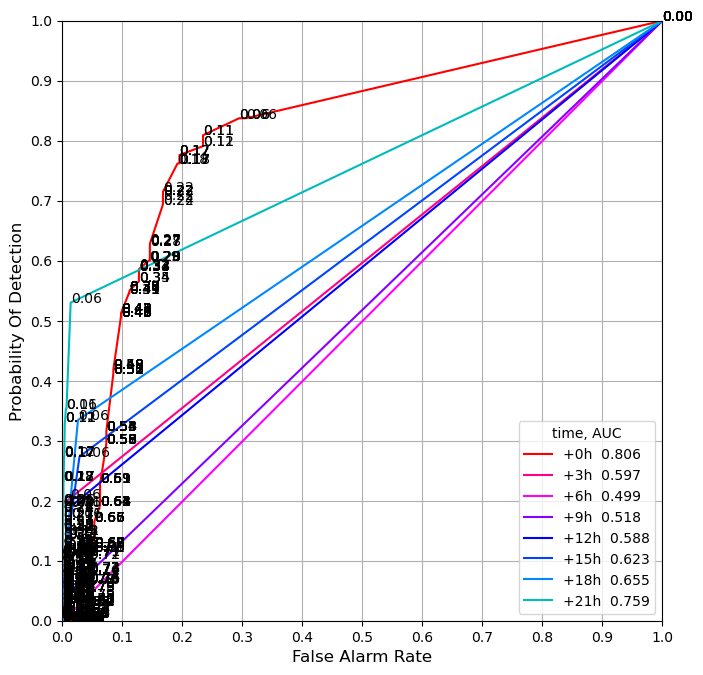

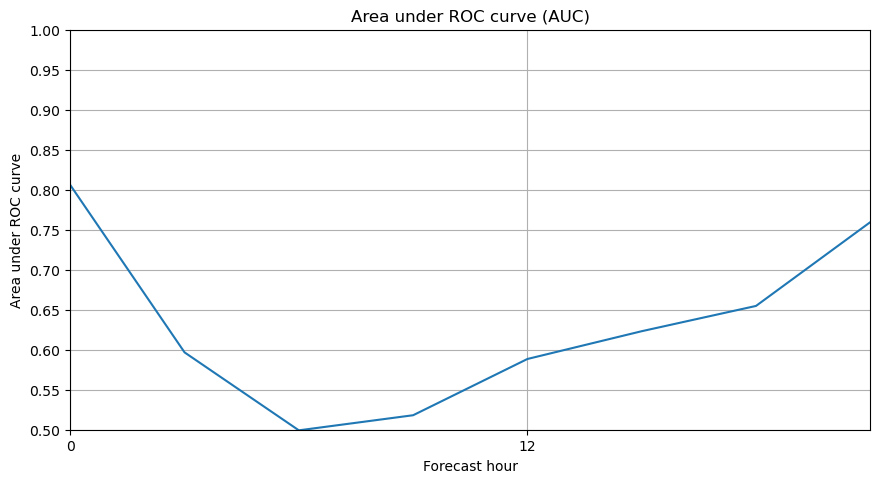

In [84]:
DrawROCCurve(roc_aucs[0:8], fprs[0:8], tprs[0:8], thresholds[0:8], forecasthours_3h[0:8], 'hres_3hrly')

#https://journals.ametsoc.org/view/journals/wefo/37/5/WAF-D-21-0195.1.xml


In [ ]:
print(thresholds[4])

In [ ]:
prob_trues_hres, prob_preds_hres = CalcReliability(observations1d_hres, forecast1d_hres, forecasthours)
    

In [ ]:
DrawReliabilityDiurnalCycle(prob_trues_hres, prob_preds_hres, forecasthours, label='hres')


In [49]:
def CalcROCCurve(observations1d, forecast1d, forecast_hours):

    roc_aucs, fprs, tprs, thresholds = [], [], [], []

    tu.Timestamp('Calculating ROC curves')

    for fh in forecast_hours:
        tu.Timestamp(str(fh))
        roc_aucs.append(roc_auc_score(observations1d[fh], forecast1d[fh]))
        fpr, tpr, threshold = roc_curve(observations1d[fh], forecast1d[fh])
        fprs.append(fpr)
        tprs.append(tpr)
        thresholds.append(threshold)
    
    return roc_aucs, fprs, tprs, thresholds

In [48]:
roc_aucs, fprs, tprs, thresholds = CalcROCCurve(observations1d_hres, forecast1d_hres, forecasthours)

NameError: name 'CalcROCCurve' is not defined

In [55]:
def DrawROCCurve(roc_aucs, fprs, tprs, thresholds, forecast_hours, label):

    tu.Timestamp('Plotting ROC curves')
    
    fig = plt.figure(figsize=(6,6))
    
    ax = fig.add_axes([0,0,1,1])
    diagonal = ax.plot([0,1],[0,1],'k:', linewidth=0.5)
    
    colorcycle = (cycler(color=['#ff0000', '#ff0088', '#ff00ff', '#8800ff', '#0000ff', '#0044ff', '#0088ff', '#00bbbb', '#00bb88', '#00bb00']))
    ax.set_prop_cycle(colorcycle)

    
    for roc_auc, fpr, tpr, threshold, fh in zip(roc_aucs, fprs, tprs, thresholds, forecast_hours):
        curve = ax.plot(fpr, tpr, label = '+' + str(fh) + 'h  ' + '{:.3f}'.format(roc_auc))
        
        for i, txt in enumerate(threshold):
            ax.annotate(txt, (fpr[i], tpr[i]))

    ax.set_xticks(np.arange(0,1.01,0.1))
    ax.set_yticks(np.arange(0,1.01,0.1))
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.0])
    ax.set_xlabel("False Alarm Rate", fontsize=12)
    ax.set_ylabel("Probability Of Detection", fontsize=12)
    ax.grid()
    
    legend = ax.legend(title='time, AUC', loc='lower right')
    
    plt.savefig(hazardtype + '_' + label + 'roc_curve.png', bbox_inches='tight')
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_axes([0,0,1,1])

    #for roc_auc, fh in zip(roc_aucs, forecast_hours):
    curve = ax.plot(forecast_hours, roc_aucs)
    ax.set_xticks(np.arange(0,forecast_hours[-1],12))
    ax.set_yticks(np.arange(0.5,1.01,0.05))
    ax.set_xlim([0.0,forecast_hours[-1]])
    ax.set_ylim([0.5,1.0])
    ax.grid()
    
    

    
    ax.set_title('Area under ROC curve (AUC)')
    ax.set_xlabel("Forecast hour")
    ax.set_ylabel("Area under ROC curve")

    plt.savefig(hazardtype + '_' + label + '_auc.png', bbox_inches='tight')
    
    return

In [ ]:
DrawROCCurve(roc_aucs, fprs, tprs, thresholds, forecasthours, 'hres_1hrly')

In [ ]:
hazardtype = 'HAIL'
obs_data_readin_hres, dates_obs_hres = ReadSummarizedHRESObsData()
VerifyHRESForecast("2024060700", hres_forecast_hours, obs_data_readin_hres, dates_obs_hres)

#roc_aucs, fprs, tprs, thresholds = CalcROCCurve(observations1d, forecast1d, forecast_hours)
#DrawROCCurve(roc_aucs, fprs, tprs, thresholds, forecast_hours)





In [37]:



def ReadForecast(hazardtype, initdtg, forecasthour, domain, filter_land=True, max_members=51):

    # This function reads and returns the data of a set of grib messages (the ensemble members)
    # and their geographical coordinates. It assumes all members have the same grid.
    # It also "temporally upscales" the forecasts from hourly to 3-hourly by inflating the probabilities
    
    global forecastbasedir
    my_forecast = np.empty([nj, ni, nm], dtype=np.float32)
    
    forecast_filename = forecastbasedir + '/' + str(initdtg) + '/' + hazardtype + '_' + str(initdtg) + '_' + str(forecasthour) + '.grib'
    grib_filehandle = open(forecast_filename, 'rb')
    
    i = 0
#    tu.Timestamp('Reading in up to ' + str(max_members) + ' members from run ' + str(initdtg) + ' at +' + str(forecasthour) + ' hours')
    
    while i < max_members:
        grib_message_id = ec.codes_grib_new_from_file(grib_filehandle)
        
        if grib_message_id == None: # last message in grib file
            break

        if i == 0: # Get latitudes and longitudes. Assume this is the same for all ensemble members 
            lats, lons = GetLatsLons(grib_message_id)
            
        my_forecast[:,:,i] = ec.codes_get_values(grib_message_id).reshape(nj, ni)
            
        i = i + 1
        ec.codes_release(grib_message_id)

    my_forecast, lats, lons = ConstrainForecastToDomain(my_forecast, lats, lons, domain)

#    tu.Timestamp('Scaling forecasts to 3 hour criterion...')
    my_forecast = 1 - (1 - my_forecast) ** 3
    
#    tu.Timestamp('Scaling forecasts to 40 km radius criterion...')
    my_forecast = 1 - (1 - my_forecast) ** 9.2
    
#    tu.Timestamp('Averaging members...')
    my_forecast = np.mean(my_forecast, axis = 2)

    lons2d, lats2d = np.meshgrid(lons, lats)
    
    if filter_land:
#        tu.Timestamp('Masking seas...')
        land_mask = globe.is_land(lats2d,lons2d)
        my_forecast[~land_mask] = np.NaN
    
    return my_forecast, lats, lons


def GetLatsLons(grib_message_id):
    
    #This function extracts and returns the latitude and longitude grid of a GRIB message
    
    firstlat     = ec.codes_get(grib_message_id, 'latitudeOfFirstGridPointInDegrees')
    firstlon     = ec.codes_get(grib_message_id, 'longitudeOfFirstGridPointInDegrees')
    steplat      = ec.codes_get(grib_message_id, 'jDirectionIncrementInDegrees')
    steplon      = ec.codes_get(grib_message_id, 'iDirectionIncrementInDegrees')
    latdirection = ec.codes_get(grib_message_id, 'jScansPositively')

    if latdirection == 0:
        steplat = -steplat

    lastlon = firstlon + ni * steplon

    lats = np.arange(firstlat, firstlat + nj * steplat, steplat)[0:nj]
    lons = np.arange(firstlon, firstlon + ni * steplon, steplon)[0:ni]
    
    lons[lons >= 180] = lons[lons >= 180] - 360
    
    return lats, lons



def ConstrainForecastToDomain(my_forecast, lats, lons, domain_given):

    # Cuts out a subsection of the grib message and flips the latitude
    
    if lats[-1] < lats[0]:
#        tu.Timestamp('Flipping latitude axis')
        lats = lats[::-1]
        my_forecast = my_forecast[::-1,:,:]
    
    domains = tu.ReadDomains(domain_given, 'ecmwf')
    lonmin, lonmax, latmin, latmax = domains[0]['lonmin'], domains[0]['lonmax'], domains[0]['latmin'], domains[0]['latmax']

    if lons[0] > lonmin:
#        tu.Timestamp('Rolling data to -180 to 180 longitude')
        mid_idx = int(len(lons)/2)
        lons = np.roll(lons, mid_idx)
        my_forecast = np.roll(my_forecast, mid_idx, axis=1)

    index_of_lonmin = np.argmax(lons >= lonmin)
    index_of_lonmax = np.argmax(lons >= lonmax)
    index_of_latmin = np.argmax(lats >= latmin)
    index_of_latmax = np.argmax(lats >= latmax)
   
    my_forecast = my_forecast[index_of_latmin:index_of_latmax, index_of_lonmin:index_of_lonmax, :]
    lats = lats[index_of_latmin:index_of_latmax]
    lons = lons[index_of_lonmin:index_of_lonmax]
    
    return my_forecast, lats, lons


def AddHours(dtg, hours):
    
    # This simple routine adds a number of hours to a certain date-time-group string
    
    init_time   = datetime.datetime.strptime(dtg, "%Y%m%d%H")
    valid_time  = init_time + datetime.timedelta(hours=hours)
        
    return valid_time.strftime('%Y%m%d%H')



In [ ]:
# This is to read in a sample forecast in order to get the latitudes and longitudes

mydtg = 2024070800
period_in_hours = 3
domain = 'EURO'
my_forecast, lres_lats, lres_lons = ReadForecast (hazardtype_long['HAIL'], mydtg, 0, domain, filter_land=True, max_members=1)
tu.Timestamp("Done")

print(lres_lats)
print(lres_lats.shape[0])

print(lres_lons)
print(lres_lons.shape[0])

#my_forecast, lats, lons = ConstrainForecastToDomain(my_forecast, lats, lons, domain)


In [ ]:
lres_fcst, lres_lats, lres_lons, dates_fcst, lres_fcst_hours = OpenSummarizedForecastFiles(domain, hazardtype, 60, lres_lats, lres_lons)

print(lres_lats)
print(lres_lats.shape)

print(lres_lons)
print(lres_lons.shape)


In [ ]:
def PlotHRESForecast():

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    #for fh in range(0, 24):
    #    my_maps[fh] = ax.pcolor(lats, lons, hres_fcst[fh,:].reshape(nj,ni), cmap='inferno', vmin=0, vmax=1)

    my_map = ax.pcolor(hres_lons, hres_lats, np.sum(hres_fcst[0:1], axis=0).reshape(hres_nj, hres_ni), cmap='inferno')
    plt.colorbar(my_map)
    plt.show()

    return

In [ ]:
hres_lats, hres_lons, hres_fcst, hres_ni, hres_nj, hres_nsteps = ReadHRESForecast(2024060700)
PlotHRESForecast()

In [ ]:
print(hres_lons[0,0])

In [ ]:
print(lres_fcst, lres_lats, lres_lons, dates_fcst, lres_fcst_hours)
    
for my_fh in lres_fcst_hours:
    print (lres_fcst[my_fh].shape)
    

In [ ]:
my_fh = 15
my_index = dates_fcst[my_fh].index('2024060715')
my_lres_forecast = lres_fcst[my_fh][:, my_index]

In [ ]:
print(my_lres_forecast.shape)




In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

print(lres_lats.shape)

print(lres_lons)

#my_map = ax.pcolor(lres_lats, lres_lons, my_lres_forecast.reshape(lres_lons.shape), cmap='inferno')

my_map = ax.pcolor(lres_lats, lres_lons, my_lres_forecast.reshape((190,360)), cmap='inferno')

plt.colorbar(my_map)
plt.show()

In [ ]:
print(lres_lats[0,:])

interp = RGI((lres_lats, lres_lons), my_lres_forecast)
lresfcst_hres = interp((hres_lats, hres_lons))

print(lresfcst_hres.shape)
print(test)